In [1]:
import pynvml
pynvml.nvmlInit()
# 这里的0是GPU id
handle = pynvml.nvmlDeviceGetHandleByIndex(0)
meminfo = pynvml.nvmlDeviceGetMemoryInfo(handle)
print(meminfo.used)

131072


In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import labelme
import base64
import io
import cv2
import matplotlib
import matplotlib.pyplot as plt
import PIL
# Root directory of the project
ROOT_DIR = os.path.abspath("./")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
import json
import keras
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
print(MODEL_DIR, COCO_MODEL_PATH)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # 按照PCI_BUS_ID顺序从0开始排列GPU设备
os.environ["CUDA_VISIBLE_DEVICES"]= '0'  # 使用0号gpu（想使用其他编号GPU，对应修改引号中的内容即可）

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
set_session(sess)

import warnings 
warnings.filterwarnings('ignore')

[WARNING] deprecation:<module>:40 - Deprecation warnings have been disabled. Set TF_ENABLE_DEPRECATION_WARNINGS=1 to re-enable them.


Using TensorFlow backend.


1.15.4
['/root/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow_core/python/keras/api/_v1', '/root/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/api/_v1', '/root/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow_core', '/root/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow_core/_api/v1']
/home/wangjy/research/maskrcnn/logs /home/wangjy/research/maskrcnn/mask_rcnn_coco.h5


In [2]:

# train config
class FacesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "faces"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    # XXX注意: self.BATCH_SIZE = self.IMAGES_PER_GPU * self.GPU_COUNT
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 6  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 1536

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (4, 8, 16, 32)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5


config = FacesConfig()

config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1536
IMAGE_META_SIZE                19
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1536 1536    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:

# dataset
class FacesDataset(utils.Dataset):
    def __init__(self, dataset_type='train'):
        super(FacesDataset, self).__init__()

        self.DATA_ROOT_DIR = './facedata'

        # Add classes
        self.add_class("faces", 1, "opencomedo")
        self.add_class("faces", 2, "closedcomedo")
        self.add_class("faces", 3, "papule")
        self.add_class("faces", 4, "nudule")
        self.add_class("faces", 5, "scar")
        self.add_class("faces", 6, "undefined")

        all_label_path_list = os.listdir(self.DATA_ROOT_DIR)
        data_len = len(all_label_path_list)

        if dataset_type=='train':
            label_path_list = all_label_path_list[:int(0.8*data_len)]
#             label_path_list = all_label_path_list[0:2]
        elif  dataset_type=='val':
            label_path_list = all_label_path_list[int(0.8*data_len):]
#             label_path_list = all_label_path_list[2:3]
        else:
            raise NotImplementedError

        # 将所有信息放到Image info 中
        sh = 1536
        sw = 1536
        for i, label_path in enumerate(label_path_list):
            # XXX:按sh,sw截取图像
            if not label_path.endswith('.json'):
                continue
            with open(os.path.join(self.DATA_ROOT_DIR, label_path), encoding='utf-8') as json_file:
                labelmeJson = json.load(json_file)
                height = labelmeJson['imageHeight'] - sh
                width = labelmeJson['imageWidth'] - sw
                # XXX:按每幅图取10个
                j = 0
                while j < 10:
                    xx = random.randint(0, height - 1)
                    yy = random.randint(0, width - 1)
                    # XXX:进行判断，否则可能会有大量没有mask的图像
                    vaild_cnt = 0
                    for i, shape in enumerate(labelmeJson['shapes']):
                        if shape['shape_type'] == "polygon":
                            # point为h, w
                            inPoints = [k for k, p in enumerate(shape['points']) if p[0]>xx and p[0]<xx+sh and p[1]>yy and p[1]<yy+sw]
                            if len(inPoints) == 0:
                                continue
                            vaild_cnt = vaild_cnt + 1
                        elif shape['shape_type'] == "circle":
                            (cx, cy) = shape['points'][0]
                            if cx>xx and cx<xx+sh and cy>yy and cy<yy+sw :
                                vaild_cnt = vaild_cnt + 1
                    if vaild_cnt <= 1:
                        if random.random() < 0.2:
                            self.add_image(source="faces", image_id=i*10+j, path=label_path, crop_coordinate = (xx, yy), crop_size=(sh, sw))
                            j = j + 1
                    else:
                        self.add_image(source="faces", image_id=i*10+j, path=label_path, crop_coordinate = (xx, yy), crop_size=(sh, sw))
                        j = j + 1
        

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        label_path = info['path']
        xx = info['crop_coordinate'][0]
        yy = info['crop_coordinate'][1]
        sh = info['crop_size'][0]
        sw = info['crop_size'][1]
        # 读取json文件
        with open(os.path.join(self.DATA_ROOT_DIR, label_path), encoding='utf-8') as json_file:
            labelmeJson = json.load(json_file)
            # height = labelmeJson['imageHeight']
            # width = labelmeJson['imageWidth']
            # shape_list = labelmeJson['shapes']
            image = self.img_b64_to_arr(labelmeJson['imageData'])
            image = image[xx:xx+sh, yy:yy+sw, :]
            return image

    def img_b64_to_arr(self, img_b64):
        img_data = base64.b64decode(img_b64)
        f = io.BytesIO()
        f.write(img_data)
        img_pil = PIL.Image.open(f)
        img_arr = np.asarray(img_pil)
        return img_arr

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "faces":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def shape_to_mask(self, img_shape, points, shape_type=None, line_width=10, point_size=5):
        mask = np.zeros(img_shape[:2], dtype=np.uint8)
        mask = PIL.Image.fromarray(mask)
        draw = PIL.ImageDraw.Draw(mask)
        xy = [tuple(point) for point in points]
        if shape_type == "circle":
            assert len(xy) == 2, "Shape of shape_type=circle must have 2 points"
            (cx, cy), (px, py) = xy
            d = math.sqrt((cx - px) ** 2 + (cy - py) ** 2)
            draw.ellipse([cx - d, cy - d, cx + d, cy + d], outline=1, fill=1)
        elif shape_type == "rectangle":
            assert len(xy) == 2, "Shape of shape_type=rectangle must have 2 points"
            draw.rectangle(xy, outline=1, fill=1)
        elif shape_type == "line":
            assert len(xy) == 2, "Shape of shape_type=line must have 2 points"
            draw.line(xy=xy, fill=1, width=line_width)
        elif shape_type == "linestrip":
            draw.line(xy=xy, fill=1, width=line_width)
        elif shape_type == "point":
            assert len(xy) == 1, "Shape of shape_type=point must have 1 points"
            cx, cy = xy[0]
            r = point_size
            draw.ellipse([cx - r, cy - r, cx + r, cy + r], outline=1, fill=1)
        else:
            assert len(xy) > 2, "Polygon must have points more than 2"
            draw.polygon(xy=xy, outline=1, fill=1)
        mask = np.array(mask, dtype=bool)
        return mask

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        label_path = info['path']
        xx = info['crop_coordinate'][0]
        yy = info['crop_coordinate'][1]
        sh = info['crop_size'][0]
        sw = info['crop_size'][1]

        # 读取json文件
        with open(os.path.join(self.DATA_ROOT_DIR, label_path), encoding='utf-8') as json_file:
            labelmeJson = json.load(json_file)
            height = labelmeJson['imageHeight']
            width = labelmeJson['imageWidth']
            shapes = labelmeJson['shapes']

            croped_points = []
            croped_shape_type = []
            croped_label = []
            for i, shape in enumerate(shapes):
                if shape['shape_type'] == "polygon":
                    # point为h, w
                    inPoints = [k for k, p in enumerate(shape['points']) if p[0]>xx and p[0]<xx+sh and p[1]>yy and p[1]<yy+sw]
                    if len(inPoints) == 0:
                        continue
                    croped_points.append(shape['points'])
                    croped_shape_type.append(shape['shape_type'])
                    croped_label.append(shape['label'])
                elif shape['shape_type'] == "circle":
                    (cx, cy) = shape['points'][0]
                    if cx>xx and cx<xx+sh and cy>yy and cy<yy+sw :
                        croped_points.append(shape['points'])
                        croped_shape_type.append(shape['shape_type'])
                        croped_label.append(shape['label'])
            
            count = len(croped_points)
            mask = np.zeros([sh, sw, count], dtype=np.uint8)

            for i, points in enumerate(croped_points):
                mask_item = self.shape_to_mask((height, width), points, croped_shape_type[i])
                mask[:, :, i] = mask_item[xx:xx+sh, yy:yy+sw]

            # Map class names to class IDs.
            class_ids = np.array([self.class_names.index(label) if label in self.class_names else self.class_names.index('undefined') for label in croped_label])
            #print('class_ids:', class_ids)
            #input()
            return mask.astype(np.bool), class_ids.astype(np.int32)


print('prepare finish')

# Training dataset
dataset_train = FacesDataset('train')
dataset_train.prepare()

# Validation dataset
dataset_val = FacesDataset('val')
dataset_val.prepare()

print('prepared ',len(dataset_train.image_ids),' croped images')

prepare finish
prepared  810  croped images


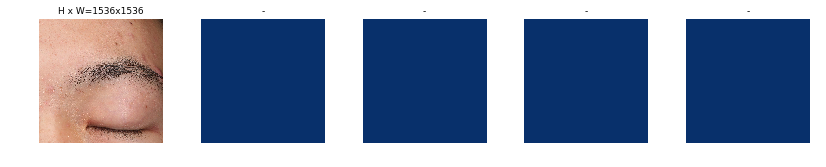

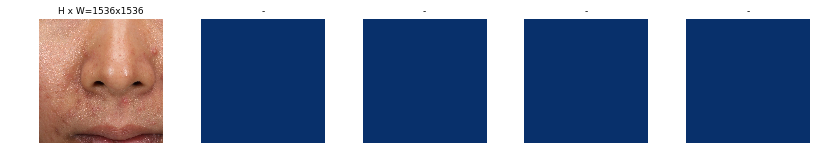

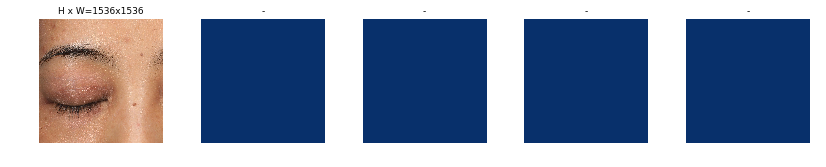

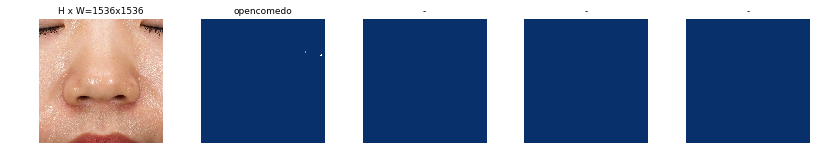

In [5]:

# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [6]:

# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)
print('load dataset and model')

[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.




load dataset and model


In [7]:

# Which weights to start with?
init_with = "last"  # imagenet, coco, or last
if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

print('init weights finished')

[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.




Re-starting from epoch 5000
init weights finished


In [9]:

# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE, epochs=6000, layers='heads')
print('train heads finished')


Starting at epoch 5000. LR=0.001

Checkpoint Path: /home/wangjy/research/maskrcnn/logs/faces20210124T1057/mask_rcnn_faces_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)


[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.




Epoch 5002/6000
100/100 [==============================] - 27s 272ms/step - loss: 0.7655 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.2531 - mrcnn_class_loss: 0.1923 - mrcnn_bbox_loss: 0.1053 - mrcnn_mask_loss: 0.1962 - val_loss: 3.6426 - val_rpn_class_loss: 3.3697e-04 - val_rpn_bbox_loss: 1.9140 - val_mrcnn_class_loss: 0.1927 - val_mrcnn_bbox_loss: 0.1953 - val_mrcnn_mask_loss: 1.3402
Epoch 5003/6000
100/100 [==============================] - 38s 377ms/step - loss: 1.8849 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.7595 - mrcnn_class_loss: 0.4704 - mrcnn_bbox_loss: 0.2364 - mrcnn_mask_loss: 0.3914 - val_loss: 2.5374 - val_rpn_class_loss: 0.0188 - val_rpn_bbox_loss: 1.3167 - val_mrcnn_class_loss: 0.0535 - val_mrcnn_bbox_loss: 0.3361 - val_mrcnn_mask_loss: 0.8122
Epoch 5004/6000
100/100 [==============================] - 24s 238ms/step - loss: 1.0178 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.4894 - mrcnn_class_loss: 0.1613 - mrcnn_bbox_loss: 0.1005 - mrcnn_mask_loss: 0.2482 - val_loss

Epoch 5023/6000
100/100 [==============================] - 30s 301ms/step - loss: 1.0022 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.4901 - mrcnn_class_loss: 0.1488 - mrcnn_bbox_loss: 0.1207 - mrcnn_mask_loss: 0.2342 - val_loss: 5.1427 - val_rpn_class_loss: 0.1042 - val_rpn_bbox_loss: 2.7078 - val_mrcnn_class_loss: 0.5673 - val_mrcnn_bbox_loss: 0.7719 - val_mrcnn_mask_loss: 0.9915
Epoch 5024/6000
100/100 [==============================] - 25s 248ms/step - loss: 0.8340 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.3945 - mrcnn_class_loss: 0.1083 - mrcnn_bbox_loss: 0.1038 - mrcnn_mask_loss: 0.2174 - val_loss: 3.9243 - val_rpn_class_loss: 0.0866 - val_rpn_bbox_loss: 1.5887 - val_mrcnn_class_loss: 0.9748 - val_mrcnn_bbox_loss: 0.5188 - val_mrcnn_mask_loss: 0.7554
Epoch 5025/6000
100/100 [==============================] - 24s 244ms/step - loss: 0.9057 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.4293 - mrcnn_class_loss: 0.1313 - mrcnn_bbox_loss: 0.1158 - mrcnn_mask_loss: 0.2140 - val_loss: 4.7

100/100 [==============================] - 24s 240ms/step - loss: 0.8474 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.4078 - mrcnn_class_loss: 0.1102 - mrcnn_bbox_loss: 0.1000 - mrcnn_mask_loss: 0.2168 - val_loss: 2.9559 - val_rpn_class_loss: 0.0014 - val_rpn_bbox_loss: 1.1581 - val_mrcnn_class_loss: 0.8933 - val_mrcnn_bbox_loss: 0.3648 - val_mrcnn_mask_loss: 0.5382
Epoch 5045/6000
100/100 [==============================] - 24s 238ms/step - loss: 0.7783 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.3696 - mrcnn_class_loss: 0.0899 - mrcnn_bbox_loss: 0.0976 - mrcnn_mask_loss: 0.2102 - val_loss: 2.2921 - val_rpn_class_loss: 0.0013 - val_rpn_bbox_loss: 0.4926 - val_mrcnn_class_loss: 0.8946 - val_mrcnn_bbox_loss: 0.2797 - val_mrcnn_mask_loss: 0.6239
Epoch 5046/6000
100/100 [==============================] - 25s 247ms/step - loss: 0.7148 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2965 - mrcnn_class_loss: 0.0904 - mrcnn_bbox_loss: 0.1000 - mrcnn_mask_loss: 0.2173 - val_loss: 2.8356 - val_rpn_cl

100/100 [==============================] - 24s 241ms/step - loss: 0.6084 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1879 - mrcnn_class_loss: 0.0860 - mrcnn_bbox_loss: 0.1076 - mrcnn_mask_loss: 0.2200 - val_loss: 6.4701 - val_rpn_class_loss: 0.1351 - val_rpn_bbox_loss: 1.6302 - val_mrcnn_class_loss: 2.9396 - val_mrcnn_bbox_loss: 0.3882 - val_mrcnn_mask_loss: 1.3769
Epoch 5066/6000
100/100 [==============================] - 24s 241ms/step - loss: 0.8682 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3953 - mrcnn_class_loss: 0.1076 - mrcnn_bbox_loss: 0.1190 - mrcnn_mask_loss: 0.2382 - val_loss: 5.4411 - val_rpn_class_loss: 0.1229 - val_rpn_bbox_loss: 1.5957 - val_mrcnn_class_loss: 2.3167 - val_mrcnn_bbox_loss: 0.4232 - val_mrcnn_mask_loss: 0.9825
Epoch 5067/6000
100/100 [==============================] - 24s 236ms/step - loss: 0.9957 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.5130 - mrcnn_class_loss: 0.1315 - mrcnn_bbox_loss: 0.1077 - mrcnn_mask_loss: 0.2337 - val_loss: 6.3272 - val_rpn_cl

100/100 [==============================] - 26s 257ms/step - loss: 0.7442 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.3367 - mrcnn_class_loss: 0.0971 - mrcnn_bbox_loss: 0.1047 - mrcnn_mask_loss: 0.1988 - val_loss: 3.5914 - val_rpn_class_loss: 0.0340 - val_rpn_bbox_loss: 1.7526 - val_mrcnn_class_loss: 1.0133 - val_mrcnn_bbox_loss: 0.3029 - val_mrcnn_mask_loss: 0.4886
Epoch 5087/6000
100/100 [==============================] - 28s 278ms/step - loss: 0.8079 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3917 - mrcnn_class_loss: 0.0951 - mrcnn_bbox_loss: 0.1063 - mrcnn_mask_loss: 0.2066 - val_loss: 4.0290 - val_rpn_class_loss: 0.0333 - val_rpn_bbox_loss: 1.9519 - val_mrcnn_class_loss: 1.3671 - val_mrcnn_bbox_loss: 0.2602 - val_mrcnn_mask_loss: 0.4166
Epoch 5088/6000
100/100 [==============================] - 25s 246ms/step - loss: 0.8339 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.3653 - mrcnn_class_loss: 0.1115 - mrcnn_bbox_loss: 0.1125 - mrcnn_mask_loss: 0.2350 - val_loss: 3.0399 - val_rpn_cl

100/100 [==============================] - 29s 292ms/step - loss: 0.8384 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.3666 - mrcnn_class_loss: 0.1095 - mrcnn_bbox_loss: 0.1112 - mrcnn_mask_loss: 0.2357 - val_loss: 4.9152 - val_rpn_class_loss: 0.0158 - val_rpn_bbox_loss: 1.4368 - val_mrcnn_class_loss: 0.7545 - val_mrcnn_bbox_loss: 1.5579 - val_mrcnn_mask_loss: 1.1503
Epoch 5108/6000
100/100 [==============================] - 32s 317ms/step - loss: 0.9916 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.4341 - mrcnn_class_loss: 0.1333 - mrcnn_bbox_loss: 0.1469 - mrcnn_mask_loss: 0.2592 - val_loss: 4.2307 - val_rpn_class_loss: 0.0251 - val_rpn_bbox_loss: 1.5387 - val_mrcnn_class_loss: 1.0650 - val_mrcnn_bbox_loss: 0.8722 - val_mrcnn_mask_loss: 0.7297
Epoch 5109/6000
100/100 [==============================] - 30s 301ms/step - loss: 0.9367 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.3990 - mrcnn_class_loss: 0.1348 - mrcnn_bbox_loss: 0.1336 - mrcnn_mask_loss: 0.2524 - val_loss: 4.2062 - val_rpn_cl

100/100 [==============================] - 26s 260ms/step - loss: 61.4318 - rpn_class_loss: 0.7904 - rpn_bbox_loss: 60.1247 - mrcnn_class_loss: 0.1280 - mrcnn_bbox_loss: 0.1441 - mrcnn_mask_loss: 0.2446 - val_loss: 4.1763 - val_rpn_class_loss: 0.0509 - val_rpn_bbox_loss: 2.0125 - val_mrcnn_class_loss: 0.6418 - val_mrcnn_bbox_loss: 0.7341 - val_mrcnn_mask_loss: 0.7371
Epoch 5129/6000
100/100 [==============================] - 25s 252ms/step - loss: 37.6275 - rpn_class_loss: 0.4437 - rpn_bbox_loss: 36.7381 - mrcnn_class_loss: 0.0966 - mrcnn_bbox_loss: 0.1216 - mrcnn_mask_loss: 0.2276 - val_loss: 3.5749 - val_rpn_class_loss: 0.0410 - val_rpn_bbox_loss: 2.5083 - val_mrcnn_class_loss: 0.2931 - val_mrcnn_bbox_loss: 0.3342 - val_mrcnn_mask_loss: 0.3983
Epoch 5130/6000
100/100 [==============================] - 24s 244ms/step - loss: 65.2784 - rpn_class_loss: 0.9258 - rpn_bbox_loss: 63.8134 - mrcnn_class_loss: 0.1306 - mrcnn_bbox_loss: 0.1468 - mrcnn_mask_loss: 0.2618 - val_loss: 4.3593 - val_

100/100 [==============================] - 24s 237ms/step - loss: 13.1274 - rpn_class_loss: 0.3406 - rpn_bbox_loss: 12.3549 - mrcnn_class_loss: 0.1052 - mrcnn_bbox_loss: 0.1192 - mrcnn_mask_loss: 0.2075 - val_loss: 5.4164 - val_rpn_class_loss: 0.1001 - val_rpn_bbox_loss: 2.4603 - val_mrcnn_class_loss: 1.2045 - val_mrcnn_bbox_loss: 0.7544 - val_mrcnn_mask_loss: 0.8970
Epoch 5150/6000
100/100 [==============================] - 25s 246ms/step - loss: 13.0210 - rpn_class_loss: 0.3059 - rpn_bbox_loss: 12.3007 - mrcnn_class_loss: 0.1045 - mrcnn_bbox_loss: 0.1131 - mrcnn_mask_loss: 0.1968 - val_loss: 4.0457 - val_rpn_class_loss: 0.0657 - val_rpn_bbox_loss: 2.3819 - val_mrcnn_class_loss: 0.3534 - val_mrcnn_bbox_loss: 0.6410 - val_mrcnn_mask_loss: 0.6037
Epoch 5151/6000
100/100 [==============================] - 25s 247ms/step - loss: 12.9546 - rpn_class_loss: 0.3223 - rpn_bbox_loss: 12.2094 - mrcnn_class_loss: 0.1196 - mrcnn_bbox_loss: 0.0996 - mrcnn_mask_loss: 0.2037 - val_loss: 4.0897 - val_

100/100 [==============================] - 26s 255ms/step - loss: 0.7611 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2983 - mrcnn_class_loss: 0.1356 - mrcnn_bbox_loss: 0.1126 - mrcnn_mask_loss: 0.2036 - val_loss: 7.3209 - val_rpn_class_loss: 0.0283 - val_rpn_bbox_loss: 3.6286 - val_mrcnn_class_loss: 2.4798 - val_mrcnn_bbox_loss: 0.4089 - val_mrcnn_mask_loss: 0.7754
Epoch 5171/6000
100/100 [==============================] - 25s 251ms/step - loss: 0.6931 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2821 - mrcnn_class_loss: 0.1023 - mrcnn_bbox_loss: 0.0946 - mrcnn_mask_loss: 0.2046 - val_loss: 6.5978 - val_rpn_class_loss: 0.0336 - val_rpn_bbox_loss: 3.3198 - val_mrcnn_class_loss: 2.0260 - val_mrcnn_bbox_loss: 0.4432 - val_mrcnn_mask_loss: 0.7751
Epoch 5172/6000
100/100 [==============================] - 26s 257ms/step - loss: 0.6885 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.3197 - mrcnn_class_loss: 0.0818 - mrcnn_bbox_loss: 0.0859 - mrcnn_mask_loss: 0.1892 - val_loss: 5.9127 - val_rpn_cl

100/100 [==============================] - 24s 241ms/step - loss: 5.2758 - rpn_class_loss: 0.1213 - rpn_bbox_loss: 4.7531 - mrcnn_class_loss: 0.1058 - mrcnn_bbox_loss: 0.1105 - mrcnn_mask_loss: 0.1852 - val_loss: 3.6006 - val_rpn_class_loss: 0.0356 - val_rpn_bbox_loss: 1.5445 - val_mrcnn_class_loss: 0.4139 - val_mrcnn_bbox_loss: 0.4253 - val_mrcnn_mask_loss: 1.1813
Epoch 5192/6000
100/100 [==============================] - 25s 245ms/step - loss: 12.1202 - rpn_class_loss: 0.1548 - rpn_bbox_loss: 11.5338 - mrcnn_class_loss: 0.0991 - mrcnn_bbox_loss: 0.1239 - mrcnn_mask_loss: 0.2086 - val_loss: 3.2979 - val_rpn_class_loss: 0.0388 - val_rpn_bbox_loss: 1.6239 - val_mrcnn_class_loss: 0.3024 - val_mrcnn_bbox_loss: 0.4524 - val_mrcnn_mask_loss: 0.8804
Epoch 5193/6000
100/100 [==============================] - 24s 238ms/step - loss: 12.0600 - rpn_class_loss: 0.1906 - rpn_bbox_loss: 11.4785 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.1034 - mrcnn_mask_loss: 0.1865 - val_loss: 3.7438 - val_rp

100/100 [==============================] - 30s 299ms/step - loss: 5.7654 - rpn_class_loss: 0.1356 - rpn_bbox_loss: 5.2039 - mrcnn_class_loss: 0.1138 - mrcnn_bbox_loss: 0.1119 - mrcnn_mask_loss: 0.2002 - val_loss: 2.5856 - val_rpn_class_loss: 0.0112 - val_rpn_bbox_loss: 0.8545 - val_mrcnn_class_loss: 0.3345 - val_mrcnn_bbox_loss: 0.4846 - val_mrcnn_mask_loss: 0.9008
Epoch 5213/6000
100/100 [==============================] - 28s 281ms/step - loss: 20.7029 - rpn_class_loss: 0.4329 - rpn_bbox_loss: 19.7700 - mrcnn_class_loss: 0.1213 - mrcnn_bbox_loss: 0.1434 - mrcnn_mask_loss: 0.2353 - val_loss: 122.7837 - val_rpn_class_loss: 1.6652 - val_rpn_bbox_loss: 119.5445 - val_mrcnn_class_loss: 0.4375 - val_mrcnn_bbox_loss: 0.4170 - val_mrcnn_mask_loss: 0.7195
Epoch 5214/6000
100/100 [==============================] - 28s 284ms/step - loss: 0.8605 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.3793 - mrcnn_class_loss: 0.1250 - mrcnn_bbox_loss: 0.1211 - mrcnn_mask_loss: 0.2223 - val_loss: 245.3221 - va

100/100 [==============================] - 25s 249ms/step - loss: 0.8621 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4205 - mrcnn_class_loss: 0.0848 - mrcnn_bbox_loss: 0.1229 - mrcnn_mask_loss: 0.2251 - val_loss: 133.8036 - val_rpn_class_loss: 5.3853 - val_rpn_bbox_loss: 126.1044 - val_mrcnn_class_loss: 1.2873 - val_mrcnn_bbox_loss: 0.4414 - val_mrcnn_mask_loss: 0.5852
Epoch 5234/6000
100/100 [==============================] - 26s 258ms/step - loss: 0.7693 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.3232 - mrcnn_class_loss: 0.1241 - mrcnn_bbox_loss: 0.1062 - mrcnn_mask_loss: 0.2068 - val_loss: 389.2746 - val_rpn_class_loss: 16.4970 - val_rpn_bbox_loss: 370.2293 - val_mrcnn_class_loss: 1.3877 - val_mrcnn_bbox_loss: 0.4201 - val_mrcnn_mask_loss: 0.7405
Epoch 5235/6000
100/100 [==============================] - 26s 258ms/step - loss: 0.7435 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3268 - mrcnn_class_loss: 0.1004 - mrcnn_bbox_loss: 0.1136 - mrcnn_mask_loss: 0.1943 - val_loss: 133.4005 -

100/100 [==============================] - 23s 226ms/step - loss: 9.4532 - rpn_class_loss: 0.2170 - rpn_bbox_loss: 8.9528 - mrcnn_class_loss: 0.0531 - mrcnn_bbox_loss: 0.0681 - mrcnn_mask_loss: 0.1622 - val_loss: 5.0592 - val_rpn_class_loss: 0.0311 - val_rpn_bbox_loss: 2.4948 - val_mrcnn_class_loss: 1.4641 - val_mrcnn_bbox_loss: 0.3786 - val_mrcnn_mask_loss: 0.6906
Epoch 5255/6000
100/100 [==============================] - 23s 226ms/step - loss: 4.9682 - rpn_class_loss: 0.1189 - rpn_bbox_loss: 4.5416 - mrcnn_class_loss: 0.0653 - mrcnn_bbox_loss: 0.0805 - mrcnn_mask_loss: 0.1620 - val_loss: 4.5123 - val_rpn_class_loss: 0.0190 - val_rpn_bbox_loss: 2.2842 - val_mrcnn_class_loss: 1.1694 - val_mrcnn_bbox_loss: 0.4360 - val_mrcnn_mask_loss: 0.6036
Epoch 5256/6000
100/100 [==============================] - 22s 224ms/step - loss: 9.4500 - rpn_class_loss: 0.2676 - rpn_bbox_loss: 8.8490 - mrcnn_class_loss: 0.0850 - mrcnn_bbox_loss: 0.0807 - mrcnn_mask_loss: 0.1677 - val_loss: 3.7986 - val_rpn_cl

100/100 [==============================] - 23s 231ms/step - loss: 0.5825 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2421 - mrcnn_class_loss: 0.0770 - mrcnn_bbox_loss: 0.0789 - mrcnn_mask_loss: 0.1751 - val_loss: 3.9069 - val_rpn_class_loss: 0.0017 - val_rpn_bbox_loss: 0.9090 - val_mrcnn_class_loss: 1.9505 - val_mrcnn_bbox_loss: 0.4260 - val_mrcnn_mask_loss: 0.6197
Epoch 5276/6000
100/100 [==============================] - 23s 228ms/step - loss: 0.6941 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.3755 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.0748 - mrcnn_mask_loss: 0.1656 - val_loss: 3.6727 - val_rpn_class_loss: 0.0033 - val_rpn_bbox_loss: 0.8605 - val_mrcnn_class_loss: 1.5706 - val_mrcnn_bbox_loss: 0.4386 - val_mrcnn_mask_loss: 0.7998
Epoch 5277/6000
100/100 [==============================] - 23s 229ms/step - loss: 0.5465 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2127 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.0822 - mrcnn_mask_loss: 0.1717 - val_loss: 3.6180 - val_rpn_cl

100/100 [==============================] - 25s 253ms/step - loss: 0.6476 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2445 - mrcnn_class_loss: 0.1057 - mrcnn_bbox_loss: 0.0929 - mrcnn_mask_loss: 0.1968 - val_loss: 3.2654 - val_rpn_class_loss: 0.0207 - val_rpn_bbox_loss: 0.7750 - val_mrcnn_class_loss: 0.7544 - val_mrcnn_bbox_loss: 0.5901 - val_mrcnn_mask_loss: 1.1251
Epoch 5297/6000
100/100 [==============================] - 25s 250ms/step - loss: 12.7442 - rpn_class_loss: 0.5049 - rpn_bbox_loss: 11.8753 - mrcnn_class_loss: 0.0860 - mrcnn_bbox_loss: 0.0871 - mrcnn_mask_loss: 0.1909 - val_loss: 3.1527 - val_rpn_class_loss: 0.0228 - val_rpn_bbox_loss: 0.9600 - val_mrcnn_class_loss: 0.4158 - val_mrcnn_bbox_loss: 0.8121 - val_mrcnn_mask_loss: 0.9421
Epoch 5298/6000
100/100 [==============================] - 24s 236ms/step - loss: 0.6322 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2751 - mrcnn_class_loss: 0.0741 - mrcnn_bbox_loss: 0.0867 - mrcnn_mask_loss: 0.1882 - val_loss: 3.3230 - val_rpn_

100/100 [==============================] - 23s 228ms/step - loss: 5.6505 - rpn_class_loss: 0.1826 - rpn_bbox_loss: 5.1085 - mrcnn_class_loss: 0.0825 - mrcnn_bbox_loss: 0.0769 - mrcnn_mask_loss: 0.2000 - val_loss: 2.7133 - val_rpn_class_loss: 0.0117 - val_rpn_bbox_loss: 0.5539 - val_mrcnn_class_loss: 1.2045 - val_mrcnn_bbox_loss: 0.2834 - val_mrcnn_mask_loss: 0.6599
Epoch 5318/6000
100/100 [==============================] - 23s 227ms/step - loss: 10.4305 - rpn_class_loss: 0.2484 - rpn_bbox_loss: 9.8980 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.1702 - val_loss: 2.4676 - val_rpn_class_loss: 0.0092 - val_rpn_bbox_loss: 0.7544 - val_mrcnn_class_loss: 0.6580 - val_mrcnn_bbox_loss: 0.2268 - val_mrcnn_mask_loss: 0.8192
Epoch 5319/6000
100/100 [==============================] - 23s 226ms/step - loss: 20.0997 - rpn_class_loss: 0.4278 - rpn_bbox_loss: 19.3756 - mrcnn_class_loss: 0.0586 - mrcnn_bbox_loss: 0.0700 - mrcnn_mask_loss: 0.1677 - val_loss: 2.8359 - val_rpn

100/100 [==============================] - 23s 230ms/step - loss: 0.5093 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2082 - mrcnn_class_loss: 0.0632 - mrcnn_bbox_loss: 0.0658 - mrcnn_mask_loss: 0.1642 - val_loss: 4.4545 - val_rpn_class_loss: 0.0544 - val_rpn_bbox_loss: 2.8608 - val_mrcnn_class_loss: 0.7589 - val_mrcnn_bbox_loss: 0.2014 - val_mrcnn_mask_loss: 0.5790
Epoch 5339/6000
100/100 [==============================] - 24s 236ms/step - loss: 0.4254 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1554 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.0627 - mrcnn_mask_loss: 0.1558 - val_loss: 5.3333 - val_rpn_class_loss: 0.0608 - val_rpn_bbox_loss: 3.2737 - val_mrcnn_class_loss: 1.0383 - val_mrcnn_bbox_loss: 0.2467 - val_mrcnn_mask_loss: 0.7137
Epoch 5340/6000
100/100 [==============================] - 23s 232ms/step - loss: 0.5272 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2265 - mrcnn_class_loss: 0.0510 - mrcnn_bbox_loss: 0.0691 - mrcnn_mask_loss: 0.1708 - val_loss: 7.8493 - val_rpn_cl

100/100 [==============================] - 23s 229ms/step - loss: 0.5385 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2413 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.0673 - mrcnn_mask_loss: 0.1581 - val_loss: 4.7532 - val_rpn_class_loss: 0.0221 - val_rpn_bbox_loss: 2.6988 - val_mrcnn_class_loss: 0.6632 - val_mrcnn_bbox_loss: 0.5613 - val_mrcnn_mask_loss: 0.8078
Epoch 5360/6000
100/100 [==============================] - 23s 226ms/step - loss: 0.5268 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.2215 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.0706 - mrcnn_mask_loss: 0.1635 - val_loss: 3.6280 - val_rpn_class_loss: 0.0196 - val_rpn_bbox_loss: 1.8377 - val_mrcnn_class_loss: 0.5995 - val_mrcnn_bbox_loss: 0.3268 - val_mrcnn_mask_loss: 0.8445
Epoch 5361/6000
100/100 [==============================] - 23s 232ms/step - loss: 0.5730 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.2872 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.0656 - mrcnn_mask_loss: 0.1596 - val_loss: 4.6108 - val_rpn_cl

100/100 [==============================] - 23s 233ms/step - loss: 0.5083 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.2174 - mrcnn_class_loss: 0.0565 - mrcnn_bbox_loss: 0.0683 - mrcnn_mask_loss: 0.1598 - val_loss: 4.4254 - val_rpn_class_loss: 0.0104 - val_rpn_bbox_loss: 2.2630 - val_mrcnn_class_loss: 0.6365 - val_mrcnn_bbox_loss: 0.6350 - val_mrcnn_mask_loss: 0.8805
Epoch 5381/6000
100/100 [==============================] - 23s 231ms/step - loss: 0.5756 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2662 - mrcnn_class_loss: 0.0570 - mrcnn_bbox_loss: 0.0805 - mrcnn_mask_loss: 0.1639 - val_loss: 3.6954 - val_rpn_class_loss: 0.0083 - val_rpn_bbox_loss: 1.8246 - val_mrcnn_class_loss: 0.5522 - val_mrcnn_bbox_loss: 0.4564 - val_mrcnn_mask_loss: 0.8539
Epoch 5382/6000
100/100 [==============================] - 23s 228ms/step - loss: 0.5262 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.2252 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.0749 - mrcnn_mask_loss: 0.1554 - val_loss: 3.9234 - val_rpn_cl

100/100 [==============================] - 23s 230ms/step - loss: 0.4860 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1766 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.0844 - mrcnn_mask_loss: 0.1667 - val_loss: 4.4271 - val_rpn_class_loss: 0.0159 - val_rpn_bbox_loss: 1.7234 - val_mrcnn_class_loss: 1.5711 - val_mrcnn_bbox_loss: 0.5616 - val_mrcnn_mask_loss: 0.5550
Epoch 5402/6000
100/100 [==============================] - 24s 236ms/step - loss: 0.5458 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2365 - mrcnn_class_loss: 0.0562 - mrcnn_bbox_loss: 0.0814 - mrcnn_mask_loss: 0.1647 - val_loss: 5.0701 - val_rpn_class_loss: 0.0125 - val_rpn_bbox_loss: 1.9648 - val_mrcnn_class_loss: 1.9058 - val_mrcnn_bbox_loss: 0.5653 - val_mrcnn_mask_loss: 0.6216
Epoch 5403/6000
100/100 [==============================] - 23s 226ms/step - loss: 0.5903 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2636 - mrcnn_class_loss: 0.0654 - mrcnn_bbox_loss: 0.0822 - mrcnn_mask_loss: 0.1714 - val_loss: 4.3430 - val_rpn_cl

100/100 [==============================] - 23s 231ms/step - loss: 4.8724 - rpn_class_loss: 0.1100 - rpn_bbox_loss: 4.4778 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.0612 - mrcnn_mask_loss: 0.1614 - val_loss: 4.2112 - val_rpn_class_loss: 0.0198 - val_rpn_bbox_loss: 1.3636 - val_mrcnn_class_loss: 1.8863 - val_mrcnn_bbox_loss: 0.3484 - val_mrcnn_mask_loss: 0.5930
Epoch 5423/6000
100/100 [==============================] - 23s 230ms/step - loss: 28.4217 - rpn_class_loss: 0.4244 - rpn_bbox_loss: 27.6618 - mrcnn_class_loss: 0.0894 - mrcnn_bbox_loss: 0.0715 - mrcnn_mask_loss: 0.1746 - val_loss: 4.2119 - val_rpn_class_loss: 0.0219 - val_rpn_bbox_loss: 1.3346 - val_mrcnn_class_loss: 1.8340 - val_mrcnn_bbox_loss: 0.4222 - val_mrcnn_mask_loss: 0.5993
Epoch 5424/6000
100/100 [==============================] - 23s 234ms/step - loss: 16.0044 - rpn_class_loss: 0.3440 - rpn_bbox_loss: 15.3214 - mrcnn_class_loss: 0.0798 - mrcnn_bbox_loss: 0.0809 - mrcnn_mask_loss: 0.1783 - val_loss: 4.2470 - val_rp

100/100 [==============================] - 24s 237ms/step - loss: 82.0528 - rpn_class_loss: 1.2584 - rpn_bbox_loss: 80.4351 - mrcnn_class_loss: 0.0794 - mrcnn_bbox_loss: 0.0893 - mrcnn_mask_loss: 0.1907 - val_loss: 3.9700 - val_rpn_class_loss: 0.0637 - val_rpn_bbox_loss: 1.3012 - val_mrcnn_class_loss: 1.0691 - val_mrcnn_bbox_loss: 0.5429 - val_mrcnn_mask_loss: 0.9932
Epoch 5444/6000
100/100 [==============================] - 24s 235ms/step - loss: 29.5480 - rpn_class_loss: 0.5805 - rpn_bbox_loss: 28.5798 - mrcnn_class_loss: 0.0908 - mrcnn_bbox_loss: 0.0941 - mrcnn_mask_loss: 0.2029 - val_loss: 3.5167 - val_rpn_class_loss: 0.0232 - val_rpn_bbox_loss: 1.0384 - val_mrcnn_class_loss: 1.1387 - val_mrcnn_bbox_loss: 0.4803 - val_mrcnn_mask_loss: 0.8362
Epoch 5445/6000
100/100 [==============================] - 24s 240ms/step - loss: 6.7786 - rpn_class_loss: 0.1921 - rpn_bbox_loss: 6.1989 - mrcnn_class_loss: 0.1066 - mrcnn_bbox_loss: 0.0833 - mrcnn_mask_loss: 0.1977 - val_loss: 3.9737 - val_rp

100/100 [==============================] - 23s 231ms/step - loss: 5.3137 - rpn_class_loss: 0.1386 - rpn_bbox_loss: 4.8534 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.0773 - mrcnn_mask_loss: 0.1726 - val_loss: 6.8757 - val_rpn_class_loss: 0.0394 - val_rpn_bbox_loss: 2.2712 - val_mrcnn_class_loss: 1.8998 - val_mrcnn_bbox_loss: 1.0959 - val_mrcnn_mask_loss: 1.5694
Epoch 5465/6000
100/100 [==============================] - 23s 230ms/step - loss: 0.5506 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2588 - mrcnn_class_loss: 0.0541 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.1562 - val_loss: 4.2278 - val_rpn_class_loss: 0.0149 - val_rpn_bbox_loss: 1.5975 - val_mrcnn_class_loss: 0.7219 - val_mrcnn_bbox_loss: 0.7431 - val_mrcnn_mask_loss: 1.1503
Epoch 5466/6000
100/100 [==============================] - 23s 233ms/step - loss: 14.7327 - rpn_class_loss: 0.3223 - rpn_bbox_loss: 14.0884 - mrcnn_class_loss: 0.0704 - mrcnn_bbox_loss: 0.0780 - mrcnn_mask_loss: 0.1735 - val_loss: 2.1142 - val_rpn_

100/100 [==============================] - 23s 228ms/step - loss: 7.8461 - rpn_class_loss: 0.1575 - rpn_bbox_loss: 7.4065 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0743 - mrcnn_mask_loss: 0.1598 - val_loss: 3.3450 - val_rpn_class_loss: 0.0288 - val_rpn_bbox_loss: 1.0057 - val_mrcnn_class_loss: 1.3387 - val_mrcnn_bbox_loss: 0.4039 - val_mrcnn_mask_loss: 0.5679
Epoch 5486/6000
100/100 [==============================] - 23s 232ms/step - loss: 0.6116 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2629 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.0838 - mrcnn_mask_loss: 0.1741 - val_loss: 2.3169 - val_rpn_class_loss: 0.0123 - val_rpn_bbox_loss: 0.8727 - val_mrcnn_class_loss: 0.7047 - val_mrcnn_bbox_loss: 0.2318 - val_mrcnn_mask_loss: 0.4954
Epoch 5487/6000
100/100 [==============================] - 23s 227ms/step - loss: 7.8356 - rpn_class_loss: 0.1509 - rpn_bbox_loss: 7.3698 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.0790 - mrcnn_mask_loss: 0.1722 - val_loss: 3.2654 - val_rpn_cl

100/100 [==============================] - 23s 232ms/step - loss: 17.5600 - rpn_class_loss: 0.6252 - rpn_bbox_loss: 16.6294 - mrcnn_class_loss: 0.0790 - mrcnn_bbox_loss: 0.0677 - mrcnn_mask_loss: 0.1586 - val_loss: 3.2703 - val_rpn_class_loss: 0.0084 - val_rpn_bbox_loss: 0.8540 - val_mrcnn_class_loss: 1.2003 - val_mrcnn_bbox_loss: 0.3934 - val_mrcnn_mask_loss: 0.8143
Epoch 5507/6000
100/100 [==============================] - 23s 230ms/step - loss: 27.6544 - rpn_class_loss: 0.9552 - rpn_bbox_loss: 26.4285 - mrcnn_class_loss: 0.0562 - mrcnn_bbox_loss: 0.0634 - mrcnn_mask_loss: 0.1511 - val_loss: 3.2260 - val_rpn_class_loss: 0.0038 - val_rpn_bbox_loss: 0.9977 - val_mrcnn_class_loss: 0.8632 - val_mrcnn_bbox_loss: 0.4988 - val_mrcnn_mask_loss: 0.8624
Epoch 5508/6000
100/100 [==============================] - 23s 228ms/step - loss: 32.3559 - rpn_class_loss: 1.5222 - rpn_bbox_loss: 30.5538 - mrcnn_class_loss: 0.0608 - mrcnn_bbox_loss: 0.0660 - mrcnn_mask_loss: 0.1532 - val_loss: 3.3212 - val_

100/100 [==============================] - 24s 236ms/step - loss: 8.2570 - rpn_class_loss: 0.1294 - rpn_bbox_loss: 7.8580 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.0705 - mrcnn_mask_loss: 0.1512 - val_loss: 3.8800 - val_rpn_class_loss: 0.0183 - val_rpn_bbox_loss: 1.2991 - val_mrcnn_class_loss: 1.4933 - val_mrcnn_bbox_loss: 0.4347 - val_mrcnn_mask_loss: 0.6345
Epoch 5528/6000
100/100 [==============================] - 25s 245ms/step - loss: 0.4169 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1604 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.0566 - mrcnn_mask_loss: 0.1467 - val_loss: 2.7519 - val_rpn_class_loss: 0.0063 - val_rpn_bbox_loss: 0.8347 - val_mrcnn_class_loss: 0.7390 - val_mrcnn_bbox_loss: 0.4456 - val_mrcnn_mask_loss: 0.7264
Epoch 5529/6000
100/100 [==============================] - 24s 239ms/step - loss: 16.0961 - rpn_class_loss: 0.2383 - rpn_bbox_loss: 15.5721 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1570 - val_loss: 3.9786 - val_rpn_

100/100 [==============================] - 23s 225ms/step - loss: 5.0114 - rpn_class_loss: 0.1867 - rpn_bbox_loss: 4.5586 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.0642 - mrcnn_mask_loss: 0.1482 - val_loss: 3.3303 - val_rpn_class_loss: 0.0332 - val_rpn_bbox_loss: 1.5094 - val_mrcnn_class_loss: 0.7668 - val_mrcnn_bbox_loss: 0.4294 - val_mrcnn_mask_loss: 0.5916
Epoch 5549/6000
100/100 [==============================] - 23s 232ms/step - loss: 9.2847 - rpn_class_loss: 0.2678 - rpn_bbox_loss: 8.7815 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.0520 - mrcnn_mask_loss: 0.1393 - val_loss: 1.7264 - val_rpn_class_loss: 0.0049 - val_rpn_bbox_loss: 0.8173 - val_mrcnn_class_loss: 0.1303 - val_mrcnn_bbox_loss: 0.4088 - val_mrcnn_mask_loss: 0.3650
Epoch 5550/6000
100/100 [==============================] - 23s 229ms/step - loss: 13.2333 - rpn_class_loss: 0.4101 - rpn_bbox_loss: 12.5420 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1564 - val_loss: 3.0904 - val_rpn_

100/100 [==============================] - 23s 231ms/step - loss: 0.3633 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1284 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1407 - val_loss: 4.4701 - val_rpn_class_loss: 0.1309 - val_rpn_bbox_loss: 2.0696 - val_mrcnn_class_loss: 0.7907 - val_mrcnn_bbox_loss: 0.5808 - val_mrcnn_mask_loss: 0.8982
Epoch 5570/6000
100/100 [==============================] - 23s 228ms/step - loss: 0.4077 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1497 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.1474 - val_loss: 4.0885 - val_rpn_class_loss: 0.1093 - val_rpn_bbox_loss: 1.6520 - val_mrcnn_class_loss: 0.7415 - val_mrcnn_bbox_loss: 0.5774 - val_mrcnn_mask_loss: 1.0082
Epoch 5571/6000
100/100 [==============================] - 23s 230ms/step - loss: 0.3387 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1086 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0466 - mrcnn_mask_loss: 0.1300 - val_loss: 4.1133 - val_rpn_cl

100/100 [==============================] - 23s 228ms/step - loss: 5.1229 - rpn_class_loss: 0.1785 - rpn_bbox_loss: 4.7151 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.1343 - val_loss: 4.4590 - val_rpn_class_loss: 0.0025 - val_rpn_bbox_loss: 1.2975 - val_mrcnn_class_loss: 0.4890 - val_mrcnn_bbox_loss: 0.8102 - val_mrcnn_mask_loss: 1.8598
Epoch 5591/6000
100/100 [==============================] - 23s 225ms/step - loss: 14.2887 - rpn_class_loss: 0.4163 - rpn_bbox_loss: 13.6538 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.0521 - mrcnn_mask_loss: 0.1325 - val_loss: 4.8569 - val_rpn_class_loss: 0.0012 - val_rpn_bbox_loss: 1.4686 - val_mrcnn_class_loss: 1.1134 - val_mrcnn_bbox_loss: 0.8418 - val_mrcnn_mask_loss: 1.4319
Epoch 5592/6000
100/100 [==============================] - 23s 225ms/step - loss: 18.3758 - rpn_class_loss: 0.4745 - rpn_bbox_loss: 17.6895 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1215 - val_loss: 4.1333 - val_rp

100/100 [==============================] - 23s 234ms/step - loss: 0.4257 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1450 - mrcnn_class_loss: 0.0647 - mrcnn_bbox_loss: 0.0612 - mrcnn_mask_loss: 0.1488 - val_loss: 4.8242 - val_rpn_class_loss: 0.0012 - val_rpn_bbox_loss: 1.8331 - val_mrcnn_class_loss: 1.2789 - val_mrcnn_bbox_loss: 0.5327 - val_mrcnn_mask_loss: 1.1784
Epoch 5612/6000
100/100 [==============================] - 23s 233ms/step - loss: 0.4078 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1496 - mrcnn_class_loss: 0.0556 - mrcnn_bbox_loss: 0.0537 - mrcnn_mask_loss: 0.1436 - val_loss: 4.6505 - val_rpn_class_loss: 0.0015 - val_rpn_bbox_loss: 1.6579 - val_mrcnn_class_loss: 1.5344 - val_mrcnn_bbox_loss: 0.4343 - val_mrcnn_mask_loss: 1.0223
Epoch 5613/6000
100/100 [==============================] - 23s 228ms/step - loss: 0.4342 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1686 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.1462 - val_loss: 4.6278 - val_rpn_cl

100/100 [==============================] - 23s 228ms/step - loss: 0.4405 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1809 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.0609 - mrcnn_mask_loss: 0.1481 - val_loss: 4.2452 - val_rpn_class_loss: 0.0088 - val_rpn_bbox_loss: 0.7396 - val_mrcnn_class_loss: 1.9898 - val_mrcnn_bbox_loss: 0.5395 - val_mrcnn_mask_loss: 0.9675
Epoch 5633/6000
100/100 [==============================] - 23s 228ms/step - loss: 0.4005 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1548 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.0532 - mrcnn_mask_loss: 0.1430 - val_loss: 3.4263 - val_rpn_class_loss: 0.0059 - val_rpn_bbox_loss: 0.9078 - val_mrcnn_class_loss: 0.8883 - val_mrcnn_bbox_loss: 0.5956 - val_mrcnn_mask_loss: 1.0287
Epoch 5634/6000
100/100 [==============================] - 23s 228ms/step - loss: 0.4263 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1841 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.0589 - mrcnn_mask_loss: 0.1366 - val_loss: 3.6805 - val_rpn_cl

100/100 [==============================] - 23s 230ms/step - loss: 0.4460 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1922 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.0587 - mrcnn_mask_loss: 0.1397 - val_loss: 3.0591 - val_rpn_class_loss: 0.0044 - val_rpn_bbox_loss: 0.8998 - val_mrcnn_class_loss: 0.6063 - val_mrcnn_bbox_loss: 0.4863 - val_mrcnn_mask_loss: 1.0623
Epoch 5654/6000
100/100 [==============================] - 23s 231ms/step - loss: 0.3891 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1445 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.0522 - mrcnn_mask_loss: 0.1415 - val_loss: 2.5806 - val_rpn_class_loss: 0.0026 - val_rpn_bbox_loss: 1.0258 - val_mrcnn_class_loss: 0.8715 - val_mrcnn_bbox_loss: 0.2014 - val_mrcnn_mask_loss: 0.4793
Epoch 5655/6000
100/100 [==============================] - 23s 229ms/step - loss: 0.4055 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1674 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.1326 - val_loss: 3.0178 - val_rpn_cl

100/100 [==============================] - 23s 232ms/step - loss: 0.4198 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1696 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.1440 - val_loss: 3.0770 - val_rpn_class_loss: 0.0035 - val_rpn_bbox_loss: 0.6621 - val_mrcnn_class_loss: 1.2171 - val_mrcnn_bbox_loss: 0.3270 - val_mrcnn_mask_loss: 0.8673
Epoch 5675/6000
100/100 [==============================] - 24s 236ms/step - loss: 0.4276 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1653 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.0592 - mrcnn_mask_loss: 0.1523 - val_loss: 3.3076 - val_rpn_class_loss: 0.0045 - val_rpn_bbox_loss: 0.6120 - val_mrcnn_class_loss: 1.2888 - val_mrcnn_bbox_loss: 0.3978 - val_mrcnn_mask_loss: 1.0045
Epoch 5676/6000
100/100 [==============================] - 24s 244ms/step - loss: 0.3878 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1398 - mrcnn_class_loss: 0.0463 - mrcnn_bbox_loss: 0.0554 - mrcnn_mask_loss: 0.1403 - val_loss: 2.8402 - val_rpn_cl

100/100 [==============================] - 24s 238ms/step - loss: 16.2394 - rpn_class_loss: 0.6607 - rpn_bbox_loss: 15.3449 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0637 - mrcnn_mask_loss: 0.1346 - val_loss: 3.6703 - val_rpn_class_loss: 0.0030 - val_rpn_bbox_loss: 0.7527 - val_mrcnn_class_loss: 1.2666 - val_mrcnn_bbox_loss: 0.6381 - val_mrcnn_mask_loss: 1.0099
Epoch 5696/6000
100/100 [==============================] - 24s 236ms/step - loss: 21.2114 - rpn_class_loss: 0.9126 - rpn_bbox_loss: 20.0565 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.0641 - mrcnn_mask_loss: 0.1357 - val_loss: 4.0187 - val_rpn_class_loss: 0.0182 - val_rpn_bbox_loss: 0.8308 - val_mrcnn_class_loss: 1.7465 - val_mrcnn_bbox_loss: 0.5000 - val_mrcnn_mask_loss: 0.9232
Epoch 5697/6000
100/100 [==============================] - 23s 231ms/step - loss: 10.6711 - rpn_class_loss: 0.4035 - rpn_bbox_loss: 10.0291 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.0583 - mrcnn_mask_loss: 0.1369 - val_loss: 4.0258 - val_

100/100 [==============================] - 23s 232ms/step - loss: 9.7395 - rpn_class_loss: 0.3882 - rpn_bbox_loss: 9.0790 - mrcnn_class_loss: 0.0604 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.1436 - val_loss: 2.6962 - val_rpn_class_loss: 0.0382 - val_rpn_bbox_loss: 0.9392 - val_mrcnn_class_loss: 0.6777 - val_mrcnn_bbox_loss: 0.4015 - val_mrcnn_mask_loss: 0.6396
Epoch 5717/6000
100/100 [==============================] - 23s 233ms/step - loss: 5.0272 - rpn_class_loss: 0.1663 - rpn_bbox_loss: 4.6051 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.0589 - mrcnn_mask_loss: 0.1336 - val_loss: 2.1793 - val_rpn_class_loss: 0.0161 - val_rpn_bbox_loss: 0.7996 - val_mrcnn_class_loss: 0.1757 - val_mrcnn_bbox_loss: 0.4162 - val_mrcnn_mask_loss: 0.7717
Epoch 5718/6000
100/100 [==============================] - 23s 229ms/step - loss: 5.0266 - rpn_class_loss: 0.2037 - rpn_bbox_loss: 4.5933 - mrcnn_class_loss: 0.0543 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.1230 - val_loss: 2.9110 - val_rpn_cl

100/100 [==============================] - 25s 249ms/step - loss: 0.4571 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1916 - mrcnn_class_loss: 0.0468 - mrcnn_bbox_loss: 0.0603 - mrcnn_mask_loss: 0.1520 - val_loss: 149.2387 - val_rpn_class_loss: 7.3483 - val_rpn_bbox_loss: 140.2370 - val_mrcnn_class_loss: 0.6315 - val_mrcnn_bbox_loss: 0.3632 - val_mrcnn_mask_loss: 0.6587
Epoch 5738/6000
100/100 [==============================] - 24s 240ms/step - loss: 0.4458 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.2029 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.1378 - val_loss: 151.3812 - val_rpn_class_loss: 7.4162 - val_rpn_bbox_loss: 142.5047 - val_mrcnn_class_loss: 0.4137 - val_mrcnn_bbox_loss: 0.3693 - val_mrcnn_mask_loss: 0.6773
Epoch 5739/6000
100/100 [==============================] - 26s 261ms/step - loss: 0.3520 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1403 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.0447 - mrcnn_mask_loss: 0.1294 - val_loss: 2.4423 - va

100/100 [==============================] - 24s 239ms/step - loss: 0.3243 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1250 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0440 - mrcnn_mask_loss: 0.1252 - val_loss: 570.3790 - val_rpn_class_loss: 28.0477 - val_rpn_bbox_loss: 540.1124 - val_mrcnn_class_loss: 1.0108 - val_mrcnn_bbox_loss: 0.3946 - val_mrcnn_mask_loss: 0.8134
Epoch 5759/6000
100/100 [==============================] - 25s 248ms/step - loss: 0.3761 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1408 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.0525 - mrcnn_mask_loss: 0.1325 - val_loss: 671.1082 - val_rpn_class_loss: 34.9143 - val_rpn_bbox_loss: 634.2528 - val_mrcnn_class_loss: 0.9928 - val_mrcnn_bbox_loss: 0.3099 - val_mrcnn_mask_loss: 0.6384
Epoch 5760/6000
100/100 [==============================] - 25s 252ms/step - loss: 0.3686 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1371 - mrcnn_class_loss: 0.0460 - mrcnn_bbox_loss: 0.0510 - mrcnn_mask_loss: 0.1295 - val_loss: 360.9234 

100/100 [==============================] - 23s 233ms/step - loss: 11.5048 - rpn_class_loss: 0.5916 - rpn_bbox_loss: 10.6880 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.0470 - mrcnn_mask_loss: 0.1269 - val_loss: 4.8156 - val_rpn_class_loss: 0.0314 - val_rpn_bbox_loss: 1.2547 - val_mrcnn_class_loss: 1.4549 - val_mrcnn_bbox_loss: 0.7714 - val_mrcnn_mask_loss: 1.3033
Epoch 5780/6000
100/100 [==============================] - 23s 231ms/step - loss: 11.2144 - rpn_class_loss: 0.4368 - rpn_bbox_loss: 10.5625 - mrcnn_class_loss: 0.0334 - mrcnn_bbox_loss: 0.0520 - mrcnn_mask_loss: 0.1298 - val_loss: 4.6563 - val_rpn_class_loss: 0.0139 - val_rpn_bbox_loss: 1.0217 - val_mrcnn_class_loss: 1.7610 - val_mrcnn_bbox_loss: 0.7112 - val_mrcnn_mask_loss: 1.1485
Epoch 5781/6000
100/100 [==============================] - 23s 232ms/step - loss: 18.5126 - rpn_class_loss: 0.8732 - rpn_bbox_loss: 17.3998 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.0574 - mrcnn_mask_loss: 0.1401 - val_loss: 5.3538 - val_

100/100 [==============================] - 24s 240ms/step - loss: 9.2242 - rpn_class_loss: 0.4404 - rpn_bbox_loss: 8.5368 - mrcnn_class_loss: 0.0560 - mrcnn_bbox_loss: 0.0525 - mrcnn_mask_loss: 0.1385 - val_loss: 4.8820 - val_rpn_class_loss: 0.0791 - val_rpn_bbox_loss: 2.4626 - val_mrcnn_class_loss: 1.0380 - val_mrcnn_bbox_loss: 0.5767 - val_mrcnn_mask_loss: 0.7256
Epoch 5801/6000
100/100 [==============================] - 24s 236ms/step - loss: 13.2883 - rpn_class_loss: 0.5920 - rpn_bbox_loss: 12.4020 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.0636 - mrcnn_mask_loss: 0.1618 - val_loss: 4.6601 - val_rpn_class_loss: 0.0659 - val_rpn_bbox_loss: 2.4330 - val_mrcnn_class_loss: 0.7991 - val_mrcnn_bbox_loss: 0.5699 - val_mrcnn_mask_loss: 0.7921
Epoch 5802/6000
100/100 [==============================] - 24s 236ms/step - loss: 4.8247 - rpn_class_loss: 0.3488 - rpn_bbox_loss: 4.2478 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.0545 - mrcnn_mask_loss: 0.1314 - val_loss: 5.4566 - val_rpn_

100/100 [==============================] - 23s 230ms/step - loss: 0.3325 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1139 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.1244 - val_loss: 3.4135 - val_rpn_class_loss: 0.0883 - val_rpn_bbox_loss: 1.6060 - val_mrcnn_class_loss: 0.4977 - val_mrcnn_bbox_loss: 0.4517 - val_mrcnn_mask_loss: 0.7697
Epoch 5822/6000
100/100 [==============================] - 23s 227ms/step - loss: 0.3267 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.0477 - mrcnn_mask_loss: 0.1205 - val_loss: 3.1754 - val_rpn_class_loss: 0.0332 - val_rpn_bbox_loss: 1.1282 - val_mrcnn_class_loss: 0.1444 - val_mrcnn_bbox_loss: 0.5450 - val_mrcnn_mask_loss: 1.3246
Epoch 5823/6000
100/100 [==============================] - 23s 228ms/step - loss: 0.2881 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.1123 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1094 - val_loss: 2.0196 - val_rpn_cl

100/100 [==============================] - 23s 233ms/step - loss: 0.3063 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.1235 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.1042 - val_loss: 4.3602 - val_rpn_class_loss: 0.0030 - val_rpn_bbox_loss: 0.8196 - val_mrcnn_class_loss: 2.2612 - val_mrcnn_bbox_loss: 0.5085 - val_mrcnn_mask_loss: 0.7679
Epoch 5843/6000
100/100 [==============================] - 23s 229ms/step - loss: 0.3146 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1277 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.0380 - mrcnn_mask_loss: 0.1134 - val_loss: 4.5959 - val_rpn_class_loss: 0.0078 - val_rpn_bbox_loss: 1.0347 - val_mrcnn_class_loss: 2.3382 - val_mrcnn_bbox_loss: 0.4950 - val_mrcnn_mask_loss: 0.7201
Epoch 5844/6000
100/100 [==============================] - 23s 231ms/step - loss: 0.2868 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1251 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0369 - mrcnn_mask_loss: 0.1025 - val_loss: 4.8133 - val_rpn_cl

100/100 [==============================] - 23s 228ms/step - loss: 5.8141 - rpn_class_loss: 0.1652 - rpn_bbox_loss: 5.4521 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0443 - mrcnn_mask_loss: 0.1159 - val_loss: 8.3201 - val_rpn_class_loss: 0.1141 - val_rpn_bbox_loss: 4.6458 - val_mrcnn_class_loss: 2.5564 - val_mrcnn_bbox_loss: 0.3453 - val_mrcnn_mask_loss: 0.6585
Epoch 5864/6000
100/100 [==============================] - 23s 228ms/step - loss: 5.7263 - rpn_class_loss: 0.1804 - rpn_bbox_loss: 5.3729 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.1143 - val_loss: 6.0394 - val_rpn_class_loss: 0.0687 - val_rpn_bbox_loss: 3.1999 - val_mrcnn_class_loss: 1.9312 - val_mrcnn_bbox_loss: 0.3055 - val_mrcnn_mask_loss: 0.5341
Epoch 5865/6000
100/100 [==============================] - 23s 226ms/step - loss: 5.6998 - rpn_class_loss: 0.1536 - rpn_bbox_loss: 5.3516 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0496 - mrcnn_mask_loss: 0.1218 - val_loss: 5.4850 - val_rpn_cl

100/100 [==============================] - 23s 225ms/step - loss: 5.0553 - rpn_class_loss: 0.4293 - rpn_bbox_loss: 4.4342 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0463 - mrcnn_mask_loss: 0.1201 - val_loss: 3.5441 - val_rpn_class_loss: 0.0441 - val_rpn_bbox_loss: 1.3783 - val_mrcnn_class_loss: 0.9310 - val_mrcnn_bbox_loss: 0.4357 - val_mrcnn_mask_loss: 0.7549
Epoch 5885/6000
100/100 [==============================] - 23s 232ms/step - loss: 18.3868 - rpn_class_loss: 1.2150 - rpn_bbox_loss: 16.9396 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1339 - val_loss: 3.7853 - val_rpn_class_loss: 0.0438 - val_rpn_bbox_loss: 1.1494 - val_mrcnn_class_loss: 1.6950 - val_mrcnn_bbox_loss: 0.3624 - val_mrcnn_mask_loss: 0.5348
Epoch 5886/6000
100/100 [==============================] - 24s 235ms/step - loss: 13.5048 - rpn_class_loss: 0.7652 - rpn_bbox_loss: 12.5052 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.0534 - mrcnn_mask_loss: 0.1409 - val_loss: 3.7840 - val_rp

100/100 [==============================] - 23s 231ms/step - loss: 4.5772 - rpn_class_loss: 0.2270 - rpn_bbox_loss: 4.1370 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.0472 - mrcnn_mask_loss: 0.1270 - val_loss: 4.1343 - val_rpn_class_loss: 0.0144 - val_rpn_bbox_loss: 1.3383 - val_mrcnn_class_loss: 1.5729 - val_mrcnn_bbox_loss: 0.5360 - val_mrcnn_mask_loss: 0.6726
Epoch 5906/6000
100/100 [==============================] - 23s 233ms/step - loss: 4.5480 - rpn_class_loss: 0.2098 - rpn_bbox_loss: 4.1372 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.1209 - val_loss: 3.8110 - val_rpn_class_loss: 0.0181 - val_rpn_bbox_loss: 1.3616 - val_mrcnn_class_loss: 1.0130 - val_mrcnn_bbox_loss: 0.7186 - val_mrcnn_mask_loss: 0.6997
Epoch 5907/6000
100/100 [==============================] - 23s 229ms/step - loss: 4.5151 - rpn_class_loss: 0.1934 - rpn_bbox_loss: 4.1195 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.0448 - mrcnn_mask_loss: 0.1196 - val_loss: 2.8335 - val_rpn_cl

100/100 [==============================] - 24s 238ms/step - loss: 4.1008 - rpn_class_loss: 0.1282 - rpn_bbox_loss: 3.7498 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1305 - val_loss: 3.1804 - val_rpn_class_loss: 0.0051 - val_rpn_bbox_loss: 1.2597 - val_mrcnn_class_loss: 0.3320 - val_mrcnn_bbox_loss: 0.5172 - val_mrcnn_mask_loss: 1.0665
Epoch 5927/6000
100/100 [==============================] - 24s 235ms/step - loss: 8.0286 - rpn_class_loss: 0.1918 - rpn_bbox_loss: 7.6262 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.0452 - mrcnn_mask_loss: 0.1265 - val_loss: 2.2806 - val_rpn_class_loss: 0.0115 - val_rpn_bbox_loss: 1.0175 - val_mrcnn_class_loss: 0.2264 - val_mrcnn_bbox_loss: 0.2937 - val_mrcnn_mask_loss: 0.7315
Epoch 5928/6000
100/100 [==============================] - 24s 236ms/step - loss: 0.3189 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1166 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.0444 - mrcnn_mask_loss: 0.1236 - val_loss: 3.2900 - val_rpn_cl

100/100 [==============================] - 23s 232ms/step - loss: 26.1717 - rpn_class_loss: 0.9571 - rpn_bbox_loss: 24.9999 - mrcnn_class_loss: 0.0494 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.1197 - val_loss: 2.3874 - val_rpn_class_loss: 0.0080 - val_rpn_bbox_loss: 1.2714 - val_mrcnn_class_loss: 0.2146 - val_mrcnn_bbox_loss: 0.2936 - val_mrcnn_mask_loss: 0.5997
Epoch 5948/6000
100/100 [==============================] - 24s 239ms/step - loss: 21.4683 - rpn_class_loss: 0.6529 - rpn_bbox_loss: 20.6002 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.1284 - val_loss: 1.7931 - val_rpn_class_loss: 0.0184 - val_rpn_bbox_loss: 1.5324 - val_mrcnn_class_loss: 0.0342 - val_mrcnn_bbox_loss: 0.0845 - val_mrcnn_mask_loss: 0.1236
Epoch 5949/6000
100/100 [==============================] - 23s 229ms/step - loss: 23.7298 - rpn_class_loss: 1.0054 - rpn_bbox_loss: 22.4773 - mrcnn_class_loss: 0.0595 - mrcnn_bbox_loss: 0.0537 - mrcnn_mask_loss: 0.1339 - val_loss: 2.2931 - val_

100/100 [==============================] - 23s 230ms/step - loss: 0.3251 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1106 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.0441 - mrcnn_mask_loss: 0.1186 - val_loss: 3.6550 - val_rpn_class_loss: 0.0318 - val_rpn_bbox_loss: 0.9382 - val_mrcnn_class_loss: 1.6633 - val_mrcnn_bbox_loss: 0.3759 - val_mrcnn_mask_loss: 0.6458
Epoch 5969/6000
100/100 [==============================] - 23s 228ms/step - loss: 0.3263 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1355 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.0443 - mrcnn_mask_loss: 0.1089 - val_loss: 3.5250 - val_rpn_class_loss: 0.0158 - val_rpn_bbox_loss: 0.7672 - val_mrcnn_class_loss: 1.1537 - val_mrcnn_bbox_loss: 0.5140 - val_mrcnn_mask_loss: 1.0743
Epoch 5970/6000
100/100 [==============================] - 23s 230ms/step - loss: 0.2959 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1089 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0354 - mrcnn_mask_loss: 0.1161 - val_loss: 2.7905 - val_rpn_cl

100/100 [==============================] - 23s 228ms/step - loss: 24.9999 - rpn_class_loss: 0.5462 - rpn_bbox_loss: 24.2807 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.1067 - val_loss: 3.5657 - val_rpn_class_loss: 0.0037 - val_rpn_bbox_loss: 1.4764 - val_mrcnn_class_loss: 1.0501 - val_mrcnn_bbox_loss: 0.2334 - val_mrcnn_mask_loss: 0.8022
Epoch 5990/6000
100/100 [==============================] - 23s 229ms/step - loss: 0.3003 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.1308 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0339 - mrcnn_mask_loss: 0.1050 - val_loss: 2.6036 - val_rpn_class_loss: 0.0055 - val_rpn_bbox_loss: 1.2375 - val_mrcnn_class_loss: 0.8074 - val_mrcnn_bbox_loss: 0.1096 - val_mrcnn_mask_loss: 0.4436
Epoch 5991/6000
100/100 [==============================] - 23s 234ms/step - loss: 17.8913 - rpn_class_loss: 0.5309 - rpn_bbox_loss: 17.1702 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.0378 - mrcnn_mask_loss: 0.1090 - val_loss: 3.8368 - val_rp

In [10]:


# Fine tune all layers
# Passing layers="all" trains all layers. You can also
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE / 10, epochs=7000, layers="all")
print('train all layers finished')


Starting at epoch 6000. LR=0.0001

Checkpoint Path: /home/wangjy/research/maskrcnn/logs/faces20210124T1057/mask_rcnn_faces_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)

100/100 [==============================] - 157s 2s/step - loss: 0.0932 - rpn_class_loss: 9.2367e-04 - rpn_bbox_loss: 0.0104 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0113 - mrcnn_mask_loss: 0.0610 - val_loss: 2.7007 - val_rpn_class_loss: 0.0017 - val_rpn_bbox_loss: 1.3741 - val_mrcnn_class_loss: 0.1069 - val_mrcnn_bbox_loss: 0.1780 - val_mrcnn_mask_loss: 1.0400
Epoch 6002/7000
100/100 [==============================] - 44s 442ms/step - loss: 0.4599 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.2701 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.0908 - val_loss: 2.3508 - val_rpn_class_loss: 0.0017 - val_rpn_bbox_loss: 1.0071 - val_mrcnn_class_loss: 0.2620 - val_mrcnn_bbox_loss: 0.2375 - val_mrcnn_mask_loss: 0.8424
Epoch 6003/7000
100/100 [==============================] - 49s 487ms/step - loss: 0.4393 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.0582 - mrcnn_bbox_loss: 0.0598 - mrcnn_mask_loss: 0.1753 - val_loss: 2.3473 - val_rpn_

100/100 [==============================] - 45s 446ms/step - loss: 0.1754 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0368 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0878 - val_loss: 6.3410 - val_rpn_class_loss: 0.0624 - val_rpn_bbox_loss: 3.4539 - val_mrcnn_class_loss: 1.0268 - val_mrcnn_bbox_loss: 0.4636 - val_mrcnn_mask_loss: 1.3343
Epoch 6023/7000
100/100 [==============================] - 44s 445ms/step - loss: 0.2430 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0813 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0997 - val_loss: 6.3329 - val_rpn_class_loss: 0.0430 - val_rpn_bbox_loss: 3.5357 - val_mrcnn_class_loss: 0.9065 - val_mrcnn_bbox_loss: 0.5016 - val_mrcnn_mask_loss: 1.3462
Epoch 6024/7000
100/100 [==============================] - 44s 441ms/step - loss: 0.3892 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0948 - mrcnn_class_loss: 0.0613 - mrcnn_bbox_loss: 0.0529 - mrcnn_mask_loss: 0.1754 - val_loss: 6.2586 - val_rpn_cl

100/100 [==============================] - 43s 435ms/step - loss: 0.2164 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0500 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.1050 - val_loss: 4.1848 - val_rpn_class_loss: 9.0107e-04 - val_rpn_bbox_loss: 0.8062 - val_mrcnn_class_loss: 2.3514 - val_mrcnn_bbox_loss: 0.2916 - val_mrcnn_mask_loss: 0.7347
Epoch 6044/7000
100/100 [==============================] - 45s 445ms/step - loss: 0.1841 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0341 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0974 - val_loss: 4.2857 - val_rpn_class_loss: 0.0014 - val_rpn_bbox_loss: 0.7014 - val_mrcnn_class_loss: 2.7251 - val_mrcnn_bbox_loss: 0.2605 - val_mrcnn_mask_loss: 0.5973
Epoch 6045/7000
100/100 [==============================] - 44s 440ms/step - loss: 0.1819 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0337 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.0211 - mrcnn_mask_loss: 0.0931 - val_loss: 3.5260 - val_rp

100/100 [==============================] - 43s 435ms/step - loss: 0.3635 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1765 - val_loss: 7.2157 - val_rpn_class_loss: 0.1612 - val_rpn_bbox_loss: 2.2828 - val_mrcnn_class_loss: 3.2041 - val_mrcnn_bbox_loss: 0.5023 - val_mrcnn_mask_loss: 1.0653
Epoch 6065/7000
100/100 [==============================] - 45s 454ms/step - loss: 0.2339 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0544 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.0321 - mrcnn_mask_loss: 0.1108 - val_loss: 6.4954 - val_rpn_class_loss: 0.1351 - val_rpn_bbox_loss: 2.8094 - val_mrcnn_class_loss: 2.2699 - val_mrcnn_bbox_loss: 0.3949 - val_mrcnn_mask_loss: 0.8861
Epoch 6066/7000
100/100 [==============================] - 43s 434ms/step - loss: 0.2168 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0596 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.0301 - mrcnn_mask_loss: 0.0995 - val_loss: 7.5241 - val_rpn_cl

100/100 [==============================] - 45s 452ms/step - loss: 0.4303 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.0703 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1802 - val_loss: 3.6621 - val_rpn_class_loss: 0.0527 - val_rpn_bbox_loss: 1.0689 - val_mrcnn_class_loss: 1.5781 - val_mrcnn_bbox_loss: 0.2376 - val_mrcnn_mask_loss: 0.7247
Epoch 6086/7000
100/100 [==============================] - 44s 442ms/step - loss: 0.2600 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0544 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1220 - val_loss: 3.8585 - val_rpn_class_loss: 0.0509 - val_rpn_bbox_loss: 1.1112 - val_mrcnn_class_loss: 1.7584 - val_mrcnn_bbox_loss: 0.2256 - val_mrcnn_mask_loss: 0.7124
Epoch 6087/7000
100/100 [==============================] - 43s 434ms/step - loss: 0.1854 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0293 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.0289 - mrcnn_mask_loss: 0.1047 - val_loss: 3.4437 - val_rpn_cl

100/100 [==============================] - 45s 447ms/step - loss: 0.6341 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.1893 - mrcnn_class_loss: 0.0988 - mrcnn_bbox_loss: 0.1022 - mrcnn_mask_loss: 0.2277 - val_loss: 4.7952 - val_rpn_class_loss: 0.0146 - val_rpn_bbox_loss: 2.1280 - val_mrcnn_class_loss: 0.9386 - val_mrcnn_bbox_loss: 0.8060 - val_mrcnn_mask_loss: 0.9081
Epoch 6107/7000
100/100 [==============================] - 44s 441ms/step - loss: 0.3916 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1205 - mrcnn_class_loss: 0.0490 - mrcnn_bbox_loss: 0.0570 - mrcnn_mask_loss: 0.1596 - val_loss: 5.2194 - val_rpn_class_loss: 0.0256 - val_rpn_bbox_loss: 1.9681 - val_mrcnn_class_loss: 1.5478 - val_mrcnn_bbox_loss: 0.6044 - val_mrcnn_mask_loss: 1.0735
Epoch 6108/7000
100/100 [==============================] - 45s 450ms/step - loss: 0.3769 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0867 - mrcnn_class_loss: 0.0667 - mrcnn_bbox_loss: 0.0555 - mrcnn_mask_loss: 0.1654 - val_loss: 5.1223 - val_rpn_cl

100/100 [==============================] - 45s 455ms/step - loss: 0.3667 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1296 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.0520 - mrcnn_mask_loss: 0.1417 - val_loss: 3.2046 - val_rpn_class_loss: 0.0241 - val_rpn_bbox_loss: 1.1949 - val_mrcnn_class_loss: 0.6469 - val_mrcnn_bbox_loss: 0.4275 - val_mrcnn_mask_loss: 0.9113
Epoch 6128/7000
100/100 [==============================] - 44s 437ms/step - loss: 0.3734 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1319 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.0486 - mrcnn_mask_loss: 0.1457 - val_loss: 2.9546 - val_rpn_class_loss: 0.0033 - val_rpn_bbox_loss: 1.0340 - val_mrcnn_class_loss: 0.6793 - val_mrcnn_bbox_loss: 0.4739 - val_mrcnn_mask_loss: 0.7641
Epoch 6129/7000
100/100 [==============================] - 44s 437ms/step - loss: 0.3263 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0924 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.0448 - mrcnn_mask_loss: 0.1368 - val_loss: 3.2166 - val_rpn_cl

100/100 [==============================] - 43s 435ms/step - loss: 0.2497 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0587 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.0309 - mrcnn_mask_loss: 0.1119 - val_loss: 4.9050 - val_rpn_class_loss: 0.0513 - val_rpn_bbox_loss: 2.0495 - val_mrcnn_class_loss: 0.9888 - val_mrcnn_bbox_loss: 0.6432 - val_mrcnn_mask_loss: 1.1721
Epoch 6149/7000
100/100 [==============================] - 45s 448ms/step - loss: 0.2518 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0632 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.0361 - mrcnn_mask_loss: 0.1224 - val_loss: 5.9726 - val_rpn_class_loss: 0.0806 - val_rpn_bbox_loss: 2.4455 - val_mrcnn_class_loss: 1.2197 - val_mrcnn_bbox_loss: 0.7659 - val_mrcnn_mask_loss: 1.4610
Epoch 6150/7000
100/100 [==============================] - 45s 453ms/step - loss: 0.1797 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.0999 - val_loss: 6.6040 - val_rpn_cl

100/100 [==============================] - 45s 445ms/step - loss: 0.4042 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1110 - mrcnn_class_loss: 0.0685 - mrcnn_bbox_loss: 0.0674 - mrcnn_mask_loss: 0.1536 - val_loss: 9.8073 - val_rpn_class_loss: 0.0360 - val_rpn_bbox_loss: 4.5475 - val_mrcnn_class_loss: 2.4371 - val_mrcnn_bbox_loss: 0.7854 - val_mrcnn_mask_loss: 2.0013
Epoch 6170/7000
100/100 [==============================] - 44s 440ms/step - loss: 0.3658 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0964 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.0663 - mrcnn_mask_loss: 0.1531 - val_loss: 8.6450 - val_rpn_class_loss: 0.0334 - val_rpn_bbox_loss: 4.0727 - val_mrcnn_class_loss: 2.2071 - val_mrcnn_bbox_loss: 0.6468 - val_mrcnn_mask_loss: 1.6849
Epoch 6171/7000
100/100 [==============================] - 44s 440ms/step - loss: 0.2898 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0655 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0494 - mrcnn_mask_loss: 0.1362 - val_loss: 9.6589 - val_rpn_cl

100/100 [==============================] - 43s 435ms/step - loss: 0.1868 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0459 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0897 - val_loss: 5.7870 - val_rpn_class_loss: 0.0312 - val_rpn_bbox_loss: 1.6779 - val_mrcnn_class_loss: 1.7278 - val_mrcnn_bbox_loss: 0.5590 - val_mrcnn_mask_loss: 1.7912
Epoch 6191/7000
100/100 [==============================] - 45s 447ms/step - loss: 0.2747 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0786 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.1164 - val_loss: 5.9115 - val_rpn_class_loss: 0.0155 - val_rpn_bbox_loss: 1.7149 - val_mrcnn_class_loss: 1.4237 - val_mrcnn_bbox_loss: 0.6247 - val_mrcnn_mask_loss: 2.1327
Epoch 6192/7000
100/100 [==============================] - 44s 440ms/step - loss: 0.3262 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.0551 - mrcnn_mask_loss: 0.1381 - val_loss: 5.9514 - val_rpn_cl

100/100 [==============================] - 45s 446ms/step - loss: 0.3551 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.1610 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0375 - mrcnn_mask_loss: 0.1149 - val_loss: 3.3043 - val_rpn_class_loss: 0.0056 - val_rpn_bbox_loss: 0.5976 - val_mrcnn_class_loss: 1.2081 - val_mrcnn_bbox_loss: 0.4047 - val_mrcnn_mask_loss: 1.0883
Epoch 6212/7000
100/100 [==============================] - 43s 432ms/step - loss: 0.3367 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.1127 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1308 - val_loss: 2.6858 - val_rpn_class_loss: 0.0055 - val_rpn_bbox_loss: 0.6460 - val_mrcnn_class_loss: 0.9089 - val_mrcnn_bbox_loss: 0.3002 - val_mrcnn_mask_loss: 0.8252
Epoch 6213/7000
100/100 [==============================] - 45s 446ms/step - loss: 0.3479 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1229 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0476 - mrcnn_mask_loss: 0.1407 - val_loss: 2.3218 - val_rpn_cl

100/100 [==============================] - 45s 452ms/step - loss: 0.4245 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.2450 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.1152 - val_loss: 355.3577 - val_rpn_class_loss: 12.1351 - val_rpn_bbox_loss: 340.2422 - val_mrcnn_class_loss: 1.6120 - val_mrcnn_bbox_loss: 0.4729 - val_mrcnn_mask_loss: 0.8954
Epoch 6233/7000
100/100 [==============================] - 44s 440ms/step - loss: 0.3408 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0885 - mrcnn_class_loss: 0.0578 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.1441 - val_loss: 95.4581 - val_rpn_class_loss: 2.9512 - val_rpn_bbox_loss: 90.1479 - val_mrcnn_class_loss: 0.8881 - val_mrcnn_bbox_loss: 0.4967 - val_mrcnn_mask_loss: 0.9741
Epoch 6234/7000
100/100 [==============================] - 44s 442ms/step - loss: 0.3549 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0937 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.0519 - mrcnn_mask_loss: 0.1628 - val_loss: 6.7678 - val

100/100 [==============================] - 44s 440ms/step - loss: 0.1339 - rpn_class_loss: 4.0339e-04 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0171 - mrcnn_mask_loss: 0.0759 - val_loss: 5.6516 - val_rpn_class_loss: 0.0050 - val_rpn_bbox_loss: 1.5422 - val_mrcnn_class_loss: 2.4097 - val_mrcnn_bbox_loss: 0.5204 - val_mrcnn_mask_loss: 1.1742
Epoch 6254/7000
100/100 [==============================] - 45s 448ms/step - loss: 0.1583 - rpn_class_loss: 3.1979e-04 - rpn_bbox_loss: 0.0451 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0205 - mrcnn_mask_loss: 0.0756 - val_loss: 5.4817 - val_rpn_class_loss: 0.0043 - val_rpn_bbox_loss: 1.7635 - val_mrcnn_class_loss: 1.9407 - val_mrcnn_bbox_loss: 0.4541 - val_mrcnn_mask_loss: 1.3191
Epoch 6255/7000
100/100 [==============================] - 44s 443ms/step - loss: 0.1485 - rpn_class_loss: 8.6395e-04 - rpn_bbox_loss: 0.0304 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0201 - mrcnn_mask_loss: 0.0741 - val_loss: 5.6063 

100/100 [==============================] - 45s 448ms/step - loss: 0.2022 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0506 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.0953 - val_loss: 4.8094 - val_rpn_class_loss: 0.0016 - val_rpn_bbox_loss: 1.0352 - val_mrcnn_class_loss: 2.2249 - val_mrcnn_bbox_loss: 0.5751 - val_mrcnn_mask_loss: 0.9726
Epoch 6275/7000
100/100 [==============================] - 43s 435ms/step - loss: 0.2084 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0590 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.0988 - val_loss: 4.5213 - val_rpn_class_loss: 0.0019 - val_rpn_bbox_loss: 1.1103 - val_mrcnn_class_loss: 1.9085 - val_mrcnn_bbox_loss: 0.5484 - val_mrcnn_mask_loss: 0.9521
Epoch 6276/7000
100/100 [==============================] - 44s 436ms/step - loss: 0.2185 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0730 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.0969 - val_loss: 4.0456 - val_rpn_cl

100/100 [==============================] - 45s 448ms/step - loss: 0.2682 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0483 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.1375 - val_loss: 2.2415 - val_rpn_class_loss: 0.0126 - val_rpn_bbox_loss: 1.9577 - val_mrcnn_class_loss: 0.0347 - val_mrcnn_bbox_loss: 0.0654 - val_mrcnn_mask_loss: 0.1711
Epoch 6296/7000
100/100 [==============================] - 44s 443ms/step - loss: 0.2405 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0511 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.0323 - mrcnn_mask_loss: 0.1245 - val_loss: 2.2228 - val_rpn_class_loss: 0.0129 - val_rpn_bbox_loss: 1.9561 - val_mrcnn_class_loss: 0.0197 - val_mrcnn_bbox_loss: 0.0647 - val_mrcnn_mask_loss: 0.1695
Epoch 6297/7000
100/100 [==============================] - 43s 433ms/step - loss: 0.2268 - rpn_class_loss: 9.9739e-04 - rpn_bbox_loss: 0.0533 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0389 - mrcnn_mask_loss: 0.1038 - val_loss: 2.3758 - val_rp

100/100 [==============================] - 43s 435ms/step - loss: 0.1814 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0479 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0235 - mrcnn_mask_loss: 0.0908 - val_loss: 3.6458 - val_rpn_class_loss: 0.0153 - val_rpn_bbox_loss: 0.8353 - val_mrcnn_class_loss: 1.6139 - val_mrcnn_bbox_loss: 0.3546 - val_mrcnn_mask_loss: 0.8266
Epoch 6317/7000
100/100 [==============================] - 45s 446ms/step - loss: 0.2232 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0577 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.0273 - mrcnn_mask_loss: 0.1028 - val_loss: 3.3661 - val_rpn_class_loss: 0.0091 - val_rpn_bbox_loss: 0.8182 - val_mrcnn_class_loss: 1.3257 - val_mrcnn_bbox_loss: 0.4053 - val_mrcnn_mask_loss: 0.8079
Epoch 6318/7000
100/100 [==============================] - 43s 434ms/step - loss: 0.2209 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.0299 - mrcnn_mask_loss: 0.1037 - val_loss: 3.6894 - val_rpn_cl

100/100 [==============================] - 45s 445ms/step - loss: 0.2056 - rpn_class_loss: 7.8898e-04 - rpn_bbox_loss: 0.0421 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.0999 - val_loss: 7.6878 - val_rpn_class_loss: 0.3978 - val_rpn_bbox_loss: 4.1206 - val_mrcnn_class_loss: 2.0887 - val_mrcnn_bbox_loss: 0.1948 - val_mrcnn_mask_loss: 0.8858
Epoch 6338/7000
100/100 [==============================] - 44s 436ms/step - loss: 0.2019 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.0276 - mrcnn_mask_loss: 0.1043 - val_loss: 4.6574 - val_rpn_class_loss: 0.1847 - val_rpn_bbox_loss: 2.5289 - val_mrcnn_class_loss: 1.1033 - val_mrcnn_bbox_loss: 0.1185 - val_mrcnn_mask_loss: 0.7220
Epoch 6339/7000
100/100 [==============================] - 44s 439ms/step - loss: 0.1774 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0358 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0953 - val_loss: 7.4547 - val_rp

100/100 [==============================] - 44s 435ms/step - loss: 0.1359 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0293 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.0178 - mrcnn_mask_loss: 0.0729 - val_loss: 4.2887 - val_rpn_class_loss: 0.0100 - val_rpn_bbox_loss: 2.2397 - val_mrcnn_class_loss: 0.4175 - val_mrcnn_bbox_loss: 0.4266 - val_mrcnn_mask_loss: 1.1948
Epoch 6359/7000
100/100 [==============================] - 44s 440ms/step - loss: 0.1574 - rpn_class_loss: 7.6300e-04 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0803 - val_loss: 4.1606 - val_rpn_class_loss: 0.0259 - val_rpn_bbox_loss: 2.2383 - val_mrcnn_class_loss: 0.5797 - val_mrcnn_bbox_loss: 0.4437 - val_mrcnn_mask_loss: 0.8730
Epoch 6360/7000
100/100 [==============================] - 44s 439ms/step - loss: 0.1708 - rpn_class_loss: 5.7448e-04 - rpn_bbox_loss: 0.0408 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0843 - val_loss: 4.1262 - va

100/100 [==============================] - 43s 432ms/step - loss: 0.1789 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0477 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.0218 - mrcnn_mask_loss: 0.0870 - val_loss: 4.1546 - val_rpn_class_loss: 0.0033 - val_rpn_bbox_loss: 1.2876 - val_mrcnn_class_loss: 1.0171 - val_mrcnn_bbox_loss: 0.5150 - val_mrcnn_mask_loss: 1.3316
Epoch 6380/7000
100/100 [==============================] - 44s 444ms/step - loss: 0.1663 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0520 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0182 - mrcnn_mask_loss: 0.0778 - val_loss: 2.9825 - val_rpn_class_loss: 0.0025 - val_rpn_bbox_loss: 0.9772 - val_mrcnn_class_loss: 0.8584 - val_mrcnn_bbox_loss: 0.3091 - val_mrcnn_mask_loss: 0.8354
Epoch 6381/7000
100/100 [==============================] - 44s 439ms/step - loss: 0.1762 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0511 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0842 - val_loss: 4.1785 - val_rpn_cl

100/100 [==============================] - 45s 445ms/step - loss: 0.2037 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0570 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0255 - mrcnn_mask_loss: 0.0950 - val_loss: 5.6865 - val_rpn_class_loss: 0.0311 - val_rpn_bbox_loss: 1.7070 - val_mrcnn_class_loss: 2.4362 - val_mrcnn_bbox_loss: 0.6103 - val_mrcnn_mask_loss: 0.9019
Epoch 6401/7000
100/100 [==============================] - 45s 448ms/step - loss: 0.2122 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0569 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.0269 - mrcnn_mask_loss: 0.1004 - val_loss: 5.5098 - val_rpn_class_loss: 0.0302 - val_rpn_bbox_loss: 1.7103 - val_mrcnn_class_loss: 2.0791 - val_mrcnn_bbox_loss: 0.6363 - val_mrcnn_mask_loss: 1.0539
Epoch 6402/7000
100/100 [==============================] - 43s 435ms/step - loss: 0.2510 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0792 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.0289 - mrcnn_mask_loss: 0.1102 - val_loss: 5.2614 - val_rpn_cl

100/100 [==============================] - 44s 440ms/step - loss: 0.2032 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0454 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0981 - val_loss: 4.4180 - val_rpn_class_loss: 0.0170 - val_rpn_bbox_loss: 0.9978 - val_mrcnn_class_loss: 2.2300 - val_mrcnn_bbox_loss: 0.3891 - val_mrcnn_mask_loss: 0.7840
Epoch 6422/7000
100/100 [==============================] - 45s 448ms/step - loss: 0.2476 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0554 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.1163 - val_loss: 3.6116 - val_rpn_class_loss: 0.0183 - val_rpn_bbox_loss: 0.8874 - val_mrcnn_class_loss: 1.6122 - val_mrcnn_bbox_loss: 0.3033 - val_mrcnn_mask_loss: 0.7905
Epoch 6423/7000
100/100 [==============================] - 45s 451ms/step - loss: 0.2091 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0527 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.0266 - mrcnn_mask_loss: 0.0948 - val_loss: 3.4038 - val_rpn_cl

100/100 [==============================] - 43s 433ms/step - loss: 0.1782 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0361 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0970 - val_loss: 9.9470 - val_rpn_class_loss: 0.0791 - val_rpn_bbox_loss: 6.4193 - val_mrcnn_class_loss: 2.3438 - val_mrcnn_bbox_loss: 0.2688 - val_mrcnn_mask_loss: 0.8360
Epoch 6443/7000
100/100 [==============================] - 45s 446ms/step - loss: 0.2683 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.1174 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.0980 - val_loss: 6.9654 - val_rpn_class_loss: 0.0581 - val_rpn_bbox_loss: 3.4262 - val_mrcnn_class_loss: 2.4811 - val_mrcnn_bbox_loss: 0.2696 - val_mrcnn_mask_loss: 0.7305
Epoch 6444/7000
100/100 [==============================] - 44s 442ms/step - loss: 0.2049 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0526 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.1006 - val_loss: 7.5816 - val_rpn_cl

100/100 [==============================] - 44s 442ms/step - loss: 0.2422 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0547 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1092 - val_loss: 5.6648 - val_rpn_class_loss: 0.0266 - val_rpn_bbox_loss: 1.8789 - val_mrcnn_class_loss: 0.7106 - val_mrcnn_bbox_loss: 1.0186 - val_mrcnn_mask_loss: 2.0301
Epoch 6464/7000
100/100 [==============================] - 45s 450ms/step - loss: 8.0331 - rpn_class_loss: 0.3231 - rpn_bbox_loss: 7.5214 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.0416 - mrcnn_mask_loss: 0.1117 - val_loss: 6.6321 - val_rpn_class_loss: 0.0285 - val_rpn_bbox_loss: 2.2881 - val_mrcnn_class_loss: 0.9224 - val_mrcnn_bbox_loss: 1.0788 - val_mrcnn_mask_loss: 2.3144
Epoch 6465/7000
100/100 [==============================] - 44s 437ms/step - loss: 21.1355 - rpn_class_loss: 0.7440 - rpn_bbox_loss: 20.1772 - mrcnn_class_loss: 0.0493 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.1214 - val_loss: 2.5966 - val_rpn_

100/100 [==============================] - 43s 433ms/step - loss: 0.1798 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0442 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.0910 - val_loss: 3.8983 - val_rpn_class_loss: 0.0668 - val_rpn_bbox_loss: 1.5651 - val_mrcnn_class_loss: 1.2507 - val_mrcnn_bbox_loss: 0.3535 - val_mrcnn_mask_loss: 0.6623
Epoch 6485/7000
100/100 [==============================] - 44s 435ms/step - loss: 0.2276 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0719 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0324 - mrcnn_mask_loss: 0.1020 - val_loss: 4.2774 - val_rpn_class_loss: 0.0604 - val_rpn_bbox_loss: 1.5505 - val_mrcnn_class_loss: 1.5391 - val_mrcnn_bbox_loss: 0.4217 - val_mrcnn_mask_loss: 0.7057
Epoch 6486/7000
100/100 [==============================] - 44s 440ms/step - loss: 0.6255 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.4795 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0303 - mrcnn_mask_loss: 0.0988 - val_loss: 4.0514 - val_rpn_cl

100/100 [==============================] - 44s 439ms/step - loss: 0.1648 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0326 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0896 - val_loss: 3.4872 - val_rpn_class_loss: 0.0199 - val_rpn_bbox_loss: 0.8985 - val_mrcnn_class_loss: 0.9536 - val_mrcnn_bbox_loss: 0.4874 - val_mrcnn_mask_loss: 1.1277
Epoch 6506/7000
100/100 [==============================] - 45s 447ms/step - loss: 0.1800 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0337 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.0980 - val_loss: 4.3130 - val_rpn_class_loss: 0.0138 - val_rpn_bbox_loss: 0.8201 - val_mrcnn_class_loss: 1.6655 - val_mrcnn_bbox_loss: 0.5872 - val_mrcnn_mask_loss: 1.2263
Epoch 6507/7000
100/100 [==============================] - 44s 440ms/step - loss: 0.1685 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0349 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0881 - val_loss: 4.2451 - val_rpn_cl

100/100 [==============================] - 44s 436ms/step - loss: 0.1740 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0432 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.0217 - mrcnn_mask_loss: 0.0848 - val_loss: 4.6370 - val_rpn_class_loss: 0.0356 - val_rpn_bbox_loss: 1.0926 - val_mrcnn_class_loss: 2.0452 - val_mrcnn_bbox_loss: 0.4470 - val_mrcnn_mask_loss: 1.0166
Epoch 6527/7000
100/100 [==============================] - 44s 442ms/step - loss: 0.1795 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0419 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0231 - mrcnn_mask_loss: 0.0935 - val_loss: 4.3509 - val_rpn_class_loss: 0.0186 - val_rpn_bbox_loss: 0.9475 - val_mrcnn_class_loss: 1.7078 - val_mrcnn_bbox_loss: 0.4498 - val_mrcnn_mask_loss: 1.2273
Epoch 6528/7000
100/100 [==============================] - 44s 440ms/step - loss: 0.1752 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0315 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0236 - mrcnn_mask_loss: 0.0940 - val_loss: 4.4897 - val_rpn_cl

100/100 [==============================] - 44s 441ms/step - loss: 9.8435 - rpn_class_loss: 0.2523 - rpn_bbox_loss: 9.4599 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0807 - val_loss: 3.0850 - val_rpn_class_loss: 0.0161 - val_rpn_bbox_loss: 0.9113 - val_mrcnn_class_loss: 1.0460 - val_mrcnn_bbox_loss: 0.4862 - val_mrcnn_mask_loss: 0.6254
Epoch 6548/7000
100/100 [==============================] - 45s 447ms/step - loss: 20.8567 - rpn_class_loss: 0.5810 - rpn_bbox_loss: 20.1328 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.0276 - mrcnn_mask_loss: 0.0863 - val_loss: 3.6560 - val_rpn_class_loss: 0.0319 - val_rpn_bbox_loss: 1.2674 - val_mrcnn_class_loss: 1.0184 - val_mrcnn_bbox_loss: 0.5024 - val_mrcnn_mask_loss: 0.8358
Epoch 6549/7000
100/100 [==============================] - 44s 439ms/step - loss: 35.2787 - rpn_class_loss: 0.9734 - rpn_bbox_loss: 34.1590 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0266 - mrcnn_mask_loss: 0.0923 - val_loss: 2.7946 - val_rp

100/100 [==============================] - 44s 438ms/step - loss: 0.1902 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0426 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.1021 - val_loss: 4.3155 - val_rpn_class_loss: 0.0508 - val_rpn_bbox_loss: 1.7645 - val_mrcnn_class_loss: 0.5418 - val_mrcnn_bbox_loss: 0.7168 - val_mrcnn_mask_loss: 1.2415
Epoch 6569/7000
100/100 [==============================] - 44s 436ms/step - loss: 0.1609 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0323 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0840 - val_loss: 4.6321 - val_rpn_class_loss: 0.0512 - val_rpn_bbox_loss: 1.5210 - val_mrcnn_class_loss: 0.9771 - val_mrcnn_bbox_loss: 0.7926 - val_mrcnn_mask_loss: 1.2902
Epoch 6570/7000
100/100 [==============================] - 44s 437ms/step - loss: 0.1985 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0456 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0257 - mrcnn_mask_loss: 0.1018 - val_loss: 4.9674 - val_rpn_cl

100/100 [==============================] - 44s 438ms/step - loss: 19.3484 - rpn_class_loss: 0.5439 - rpn_bbox_loss: 18.6420 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0290 - mrcnn_mask_loss: 0.1041 - val_loss: 3.8024 - val_rpn_class_loss: 0.0043 - val_rpn_bbox_loss: 1.1729 - val_mrcnn_class_loss: 0.4090 - val_mrcnn_bbox_loss: 0.6342 - val_mrcnn_mask_loss: 1.5820
Epoch 6590/7000
100/100 [==============================] - 44s 443ms/step - loss: 20.1099 - rpn_class_loss: 0.6454 - rpn_bbox_loss: 19.3021 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.0270 - mrcnn_mask_loss: 0.1021 - val_loss: 3.7736 - val_rpn_class_loss: 0.0037 - val_rpn_bbox_loss: 1.0631 - val_mrcnn_class_loss: 0.2747 - val_mrcnn_bbox_loss: 0.6822 - val_mrcnn_mask_loss: 1.7500
Epoch 6591/7000
100/100 [==============================] - 44s 438ms/step - loss: 33.8866 - rpn_class_loss: 1.0716 - rpn_bbox_loss: 32.6816 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0949 - val_loss: 4.2285 - val_

100/100 [==============================] - 44s 437ms/step - loss: 0.1588 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0337 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0201 - mrcnn_mask_loss: 0.0864 - val_loss: 5.2248 - val_rpn_class_loss: 0.0097 - val_rpn_bbox_loss: 1.5086 - val_mrcnn_class_loss: 2.3829 - val_mrcnn_bbox_loss: 0.2934 - val_mrcnn_mask_loss: 1.0302
Epoch 6611/7000
100/100 [==============================] - 44s 445ms/step - loss: 0.2112 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0510 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.0309 - mrcnn_mask_loss: 0.1065 - val_loss: 5.3128 - val_rpn_class_loss: 0.0026 - val_rpn_bbox_loss: 1.3264 - val_mrcnn_class_loss: 2.3891 - val_mrcnn_bbox_loss: 0.3702 - val_mrcnn_mask_loss: 1.2244
Epoch 6612/7000
100/100 [==============================] - 44s 439ms/step - loss: 0.2087 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0352 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.1099 - val_loss: 5.0332 - val_rpn_cl

100/100 [==============================] - 43s 431ms/step - loss: 0.1665 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0433 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0226 - mrcnn_mask_loss: 0.0829 - val_loss: 3.8909 - val_rpn_class_loss: 0.0027 - val_rpn_bbox_loss: 0.7411 - val_mrcnn_class_loss: 1.3568 - val_mrcnn_bbox_loss: 0.4031 - val_mrcnn_mask_loss: 1.3872
Epoch 6632/7000
100/100 [==============================] - 44s 440ms/step - loss: 0.1643 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0454 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0214 - mrcnn_mask_loss: 0.0831 - val_loss: 4.2069 - val_rpn_class_loss: 0.0051 - val_rpn_bbox_loss: 0.7680 - val_mrcnn_class_loss: 1.8753 - val_mrcnn_bbox_loss: 0.4178 - val_mrcnn_mask_loss: 1.1407
Epoch 6633/7000
100/100 [==============================] - 43s 432ms/step - loss: 0.1616 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0366 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.0198 - mrcnn_mask_loss: 0.0843 - val_loss: 4.3250 - val_rpn_cl

100/100 [==============================] - 50s 495ms/step - loss: 0.2280 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0704 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.1001 - val_loss: 2.6030 - val_rpn_class_loss: 0.0021 - val_rpn_bbox_loss: 1.2492 - val_mrcnn_class_loss: 0.6065 - val_mrcnn_bbox_loss: 0.1678 - val_mrcnn_mask_loss: 0.5774
Epoch 6653/7000
100/100 [==============================] - 52s 520ms/step - loss: 0.2182 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0581 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.0998 - val_loss: 2.3198 - val_rpn_class_loss: 0.0012 - val_rpn_bbox_loss: 1.1646 - val_mrcnn_class_loss: 0.4950 - val_mrcnn_bbox_loss: 0.1414 - val_mrcnn_mask_loss: 0.5176
Epoch 6654/7000
100/100 [==============================] - 45s 445ms/step - loss: 0.2057 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0587 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0258 - mrcnn_mask_loss: 0.0977 - val_loss: 2.0694 - val_rpn_cl

100/100 [==============================] - 45s 452ms/step - loss: 0.2427 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0530 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1145 - val_loss: 3.2511 - val_rpn_class_loss: 0.0068 - val_rpn_bbox_loss: 0.6879 - val_mrcnn_class_loss: 0.9113 - val_mrcnn_bbox_loss: 0.4387 - val_mrcnn_mask_loss: 1.2064
Epoch 6674/7000
100/100 [==============================] - 45s 451ms/step - loss: 0.2488 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0437 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1259 - val_loss: 3.4476 - val_rpn_class_loss: 0.0047 - val_rpn_bbox_loss: 0.5865 - val_mrcnn_class_loss: 1.0198 - val_mrcnn_bbox_loss: 0.4749 - val_mrcnn_mask_loss: 1.3617
Epoch 6675/7000
100/100 [==============================] - 44s 443ms/step - loss: 0.2414 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0506 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.0377 - mrcnn_mask_loss: 0.1187 - val_loss: 3.2736 - val_rpn_cl

100/100 [==============================] - 48s 477ms/step - loss: 37.7004 - rpn_class_loss: 1.0239 - rpn_bbox_loss: 36.5372 - mrcnn_class_loss: 0.0080 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.1035 - val_loss: 4.6019 - val_rpn_class_loss: 0.0419 - val_rpn_bbox_loss: 1.1694 - val_mrcnn_class_loss: 1.9733 - val_mrcnn_bbox_loss: 0.3902 - val_mrcnn_mask_loss: 1.0271
Epoch 6695/7000
100/100 [==============================] - 45s 452ms/step - loss: 41.3676 - rpn_class_loss: 1.2056 - rpn_bbox_loss: 40.0297 - mrcnn_class_loss: 0.0074 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.1010 - val_loss: 4.1427 - val_rpn_class_loss: 0.0186 - val_rpn_bbox_loss: 0.8509 - val_mrcnn_class_loss: 1.3214 - val_mrcnn_bbox_loss: 0.5305 - val_mrcnn_mask_loss: 1.4213
Epoch 6696/7000
100/100 [==============================] - 44s 440ms/step - loss: 30.1500 - rpn_class_loss: 0.9238 - rpn_bbox_loss: 29.0952 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.0924 - val_loss: 0.7504 - val_

100/100 [==============================] - 44s 437ms/step - loss: 0.2171 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0540 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0296 - mrcnn_mask_loss: 0.1054 - val_loss: 3.2908 - val_rpn_class_loss: 0.0292 - val_rpn_bbox_loss: 1.4522 - val_mrcnn_class_loss: 0.3405 - val_mrcnn_bbox_loss: 0.4293 - val_mrcnn_mask_loss: 1.0396
Epoch 6716/7000
100/100 [==============================] - 48s 475ms/step - loss: 0.1984 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0495 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.0934 - val_loss: 2.8520 - val_rpn_class_loss: 0.0228 - val_rpn_bbox_loss: 1.4413 - val_mrcnn_class_loss: 0.2200 - val_mrcnn_bbox_loss: 0.3676 - val_mrcnn_mask_loss: 0.8002
Epoch 6717/7000
100/100 [==============================] - 45s 447ms/step - loss: 0.1939 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0478 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.0260 - mrcnn_mask_loss: 0.0957 - val_loss: 3.6947 - val_rpn_cl

100/100 [==============================] - 43s 434ms/step - loss: 0.1536 - rpn_class_loss: 7.5729e-04 - rpn_bbox_loss: 0.0392 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0209 - mrcnn_mask_loss: 0.0787 - val_loss: 3.7285 - val_rpn_class_loss: 9.1571e-04 - val_rpn_bbox_loss: 1.0638 - val_mrcnn_class_loss: 0.7521 - val_mrcnn_bbox_loss: 0.4829 - val_mrcnn_mask_loss: 1.4288
Epoch 6737/7000
100/100 [==============================] - 43s 433ms/step - loss: 0.1411 - rpn_class_loss: 6.2476e-04 - rpn_bbox_loss: 0.0391 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.0156 - mrcnn_mask_loss: 0.0762 - val_loss: 3.4669 - val_rpn_class_loss: 9.7477e-04 - val_rpn_bbox_loss: 1.0295 - val_mrcnn_class_loss: 0.6483 - val_mrcnn_bbox_loss: 0.4088 - val_mrcnn_mask_loss: 1.3793
Epoch 6738/7000
100/100 [==============================] - 43s 432ms/step - loss: 0.1415 - rpn_class_loss: 6.4019e-04 - rpn_bbox_loss: 0.0375 - mrcnn_class_loss: 0.0069 - mrcnn_bbox_loss: 0.0194 - mrcnn_mask_loss: 0.0771 - val_loss:

100/100 [==============================] - 48s 482ms/step - loss: 0.2739 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0799 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0382 - mrcnn_mask_loss: 0.1173 - val_loss: 588.9073 - val_rpn_class_loss: 14.9048 - val_rpn_bbox_loss: 571.6466 - val_mrcnn_class_loss: 1.1566 - val_mrcnn_bbox_loss: 0.3597 - val_mrcnn_mask_loss: 0.8394
Epoch 6758/7000
100/100 [==============================] - 49s 494ms/step - loss: 0.2866 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0746 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.1300 - val_loss: 590.4008 - val_rpn_class_loss: 14.9920 - val_rpn_bbox_loss: 573.3255 - val_mrcnn_class_loss: 0.9569 - val_mrcnn_bbox_loss: 0.3306 - val_mrcnn_mask_loss: 0.7959
Epoch 6759/7000
100/100 [==============================] - 47s 470ms/step - loss: 0.2127 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0493 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0321 - mrcnn_mask_loss: 0.1021 - val_loss: 582.9446 

100/100 [==============================] - 44s 436ms/step - loss: 18.6309 - rpn_class_loss: 0.6544 - rpn_bbox_loss: 17.8017 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.0305 - mrcnn_mask_loss: 0.1033 - val_loss: 4.3468 - val_rpn_class_loss: 0.0024 - val_rpn_bbox_loss: 1.0310 - val_mrcnn_class_loss: 1.3051 - val_mrcnn_bbox_loss: 0.7183 - val_mrcnn_mask_loss: 1.2899
Epoch 6779/7000
100/100 [==============================] - 45s 446ms/step - loss: 29.4721 - rpn_class_loss: 0.9114 - rpn_bbox_loss: 28.3793 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1040 - val_loss: 4.7018 - val_rpn_class_loss: 0.0222 - val_rpn_bbox_loss: 1.3487 - val_mrcnn_class_loss: 1.2385 - val_mrcnn_bbox_loss: 0.7512 - val_mrcnn_mask_loss: 1.3412
Epoch 6780/7000
100/100 [==============================] - 44s 441ms/step - loss: 39.9356 - rpn_class_loss: 1.1663 - rpn_bbox_loss: 38.5726 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.0357 - mrcnn_mask_loss: 0.1162 - val_loss: 3.7069 - val_

100/100 [==============================] - 44s 435ms/step - loss: 29.2114 - rpn_class_loss: 1.2357 - rpn_bbox_loss: 27.7925 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.0272 - mrcnn_mask_loss: 0.1271 - val_loss: 6.0828 - val_rpn_class_loss: 0.1266 - val_rpn_bbox_loss: 2.4560 - val_mrcnn_class_loss: 1.6515 - val_mrcnn_bbox_loss: 0.4865 - val_mrcnn_mask_loss: 1.3622
Epoch 6800/7000
100/100 [==============================] - 43s 435ms/step - loss: 16.1284 - rpn_class_loss: 0.7588 - rpn_bbox_loss: 15.2171 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0211 - mrcnn_mask_loss: 0.1101 - val_loss: 4.2330 - val_rpn_class_loss: 0.0631 - val_rpn_bbox_loss: 2.4413 - val_mrcnn_class_loss: 0.7635 - val_mrcnn_bbox_loss: 0.2786 - val_mrcnn_mask_loss: 0.6864
Epoch 6801/7000
100/100 [==============================] - 44s 442ms/step - loss: 6.9965 - rpn_class_loss: 0.3535 - rpn_bbox_loss: 6.4938 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.0985 - val_loss: 4.1079 - val_rp

100/100 [==============================] - 44s 437ms/step - loss: 0.1356 - rpn_class_loss: 8.1236e-04 - rpn_bbox_loss: 0.0225 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0174 - mrcnn_mask_loss: 0.0776 - val_loss: 2.3457 - val_rpn_class_loss: 0.0187 - val_rpn_bbox_loss: 0.9221 - val_mrcnn_class_loss: 0.4508 - val_mrcnn_bbox_loss: 0.2933 - val_mrcnn_mask_loss: 0.6609
Epoch 6821/7000
100/100 [==============================] - 43s 434ms/step - loss: 0.1350 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0223 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0167 - mrcnn_mask_loss: 0.0777 - val_loss: 0.9017 - val_rpn_class_loss: 0.0010 - val_rpn_bbox_loss: 0.1469 - val_mrcnn_class_loss: 0.0935 - val_mrcnn_bbox_loss: 0.1364 - val_mrcnn_mask_loss: 0.5239
Epoch 6822/7000
100/100 [==============================] - 43s 432ms/step - loss: 0.1281 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0145 - mrcnn_mask_loss: 0.0729 - val_loss: 1.2246 - val_rp

100/100 [==============================] - 45s 446ms/step - loss: 0.1443 - rpn_class_loss: 9.1487e-04 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.0166 - mrcnn_mask_loss: 0.0787 - val_loss: 4.9276 - val_rpn_class_loss: 0.0049 - val_rpn_bbox_loss: 0.8425 - val_mrcnn_class_loss: 2.7228 - val_mrcnn_bbox_loss: 0.5637 - val_mrcnn_mask_loss: 0.7936
Epoch 6842/7000
100/100 [==============================] - 44s 435ms/step - loss: 0.1373 - rpn_class_loss: 9.0217e-04 - rpn_bbox_loss: 0.0261 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0165 - mrcnn_mask_loss: 0.0804 - val_loss: 4.2592 - val_rpn_class_loss: 0.0043 - val_rpn_bbox_loss: 0.7605 - val_mrcnn_class_loss: 2.2090 - val_mrcnn_bbox_loss: 0.4697 - val_mrcnn_mask_loss: 0.8157
Epoch 6843/7000
100/100 [==============================] - 44s 445ms/step - loss: 0.1502 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0358 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0175 - mrcnn_mask_loss: 0.0791 - val_loss: 4.7911 - va

100/100 [==============================] - 45s 446ms/step - loss: 0.1190 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0231 - mrcnn_class_loss: 0.0065 - mrcnn_bbox_loss: 0.0169 - mrcnn_mask_loss: 0.0711 - val_loss: 13.1423 - val_rpn_class_loss: 0.1479 - val_rpn_bbox_loss: 9.3862 - val_mrcnn_class_loss: 2.3287 - val_mrcnn_bbox_loss: 0.3427 - val_mrcnn_mask_loss: 0.9368
Epoch 6863/7000
100/100 [==============================] - 44s 440ms/step - loss: 0.1269 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0257 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0155 - mrcnn_mask_loss: 0.0751 - val_loss: 12.8254 - val_rpn_class_loss: 0.1545 - val_rpn_bbox_loss: 9.4894 - val_mrcnn_class_loss: 1.9991 - val_mrcnn_bbox_loss: 0.3808 - val_mrcnn_mask_loss: 0.8016
Epoch 6864/7000
100/100 [==============================] - 45s 448ms/step - loss: 0.1360 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0282 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0178 - mrcnn_mask_loss: 0.0784 - val_loss: 13.4527 - val_rpn

100/100 [==============================] - 44s 441ms/step - loss: 0.1648 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.0921 - val_loss: 4.9970 - val_rpn_class_loss: 0.0583 - val_rpn_bbox_loss: 1.0789 - val_mrcnn_class_loss: 2.6224 - val_mrcnn_bbox_loss: 0.5056 - val_mrcnn_mask_loss: 0.7318
Epoch 6884/7000
100/100 [==============================] - 44s 443ms/step - loss: 0.1509 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0255 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0229 - mrcnn_mask_loss: 0.0857 - val_loss: 4.7647 - val_rpn_class_loss: 0.0624 - val_rpn_bbox_loss: 1.1054 - val_mrcnn_class_loss: 2.3905 - val_mrcnn_bbox_loss: 0.5034 - val_mrcnn_mask_loss: 0.7029
Epoch 6885/7000
100/100 [==============================] - 47s 465ms/step - loss: 0.1632 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.0206 - mrcnn_mask_loss: 0.0915 - val_loss: 4.4831 - val_rpn_cl

100/100 [==============================] - 44s 439ms/step - loss: 0.1707 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0316 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.0269 - mrcnn_mask_loss: 0.0904 - val_loss: 4.1448 - val_rpn_class_loss: 0.0062 - val_rpn_bbox_loss: 1.5922 - val_mrcnn_class_loss: 1.1718 - val_mrcnn_bbox_loss: 0.4913 - val_mrcnn_mask_loss: 0.8833
Epoch 6905/7000
100/100 [==============================] - 44s 435ms/step - loss: 0.1736 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0463 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0230 - mrcnn_mask_loss: 0.0866 - val_loss: 3.0013 - val_rpn_class_loss: 0.0065 - val_rpn_bbox_loss: 1.1381 - val_mrcnn_class_loss: 0.6716 - val_mrcnn_bbox_loss: 0.3283 - val_mrcnn_mask_loss: 0.8568
Epoch 6906/7000
100/100 [==============================] - 44s 435ms/step - loss: 0.1623 - rpn_class_loss: 8.1209e-04 - rpn_bbox_loss: 0.0536 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.0174 - mrcnn_mask_loss: 0.0780 - val_loss: 4.3943 - val_rp

100/100 [==============================] - 51s 515ms/step - loss: 0.2074 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0451 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.1011 - val_loss: 2.8675 - val_rpn_class_loss: 0.0127 - val_rpn_bbox_loss: 0.9305 - val_mrcnn_class_loss: 0.8378 - val_mrcnn_bbox_loss: 0.2558 - val_mrcnn_mask_loss: 0.8308
Epoch 6926/7000
100/100 [==============================] - 51s 508ms/step - loss: 0.2053 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0432 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.0285 - mrcnn_mask_loss: 0.1067 - val_loss: 3.3091 - val_rpn_class_loss: 0.0068 - val_rpn_bbox_loss: 1.1222 - val_mrcnn_class_loss: 0.9209 - val_mrcnn_bbox_loss: 0.3930 - val_mrcnn_mask_loss: 0.8663
Epoch 6927/7000
100/100 [==============================] - 48s 478ms/step - loss: 0.1940 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0415 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0266 - mrcnn_mask_loss: 0.1023 - val_loss: 3.1028 - val_rpn_cl

100/100 [==============================] - 44s 443ms/step - loss: 0.1539 - rpn_class_loss: 9.5102e-04 - rpn_bbox_loss: 0.0415 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0189 - mrcnn_mask_loss: 0.0771 - val_loss: 1.7867 - val_rpn_class_loss: 0.0174 - val_rpn_bbox_loss: 1.4568 - val_mrcnn_class_loss: 0.1169 - val_mrcnn_bbox_loss: 0.0456 - val_mrcnn_mask_loss: 0.1500
Epoch 6947/7000
100/100 [==============================] - 44s 441ms/step - loss: 0.1549 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0407 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.0202 - mrcnn_mask_loss: 0.0735 - val_loss: 1.7967 - val_rpn_class_loss: 0.0182 - val_rpn_bbox_loss: 1.4189 - val_mrcnn_class_loss: 0.1615 - val_mrcnn_bbox_loss: 0.0421 - val_mrcnn_mask_loss: 0.1560
Epoch 6948/7000
100/100 [==============================] - 44s 442ms/step - loss: 0.1458 - rpn_class_loss: 9.0041e-04 - rpn_bbox_loss: 0.0349 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0195 - mrcnn_mask_loss: 0.0753 - val_loss: 2.1152 - va

100/100 [==============================] - 44s 439ms/step - loss: 0.1603 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.0816 - val_loss: 5.8589 - val_rpn_class_loss: 0.0318 - val_rpn_bbox_loss: 3.5540 - val_mrcnn_class_loss: 1.1627 - val_mrcnn_bbox_loss: 0.3092 - val_mrcnn_mask_loss: 0.8011
Epoch 6968/7000
100/100 [==============================] - 44s 443ms/step - loss: 0.1436 - rpn_class_loss: 7.2901e-04 - rpn_bbox_loss: 0.0236 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0226 - mrcnn_mask_loss: 0.0811 - val_loss: 5.4480 - val_rpn_class_loss: 0.0242 - val_rpn_bbox_loss: 2.2579 - val_mrcnn_class_loss: 1.9130 - val_mrcnn_bbox_loss: 0.4774 - val_mrcnn_mask_loss: 0.7755
Epoch 6969/7000
100/100 [==============================] - 43s 435ms/step - loss: 0.1629 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0353 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0213 - mrcnn_mask_loss: 0.0816 - val_loss: 6.1573 - val_rp

100/100 [==============================] - 51s 510ms/step - loss: 0.1107 - rpn_class_loss: 8.4367e-04 - rpn_bbox_loss: 0.0328 - mrcnn_class_loss: 0.0042 - mrcnn_bbox_loss: 0.0097 - mrcnn_mask_loss: 0.0632 - val_loss: 4.7543 - val_rpn_class_loss: 0.0070 - val_rpn_bbox_loss: 0.9370 - val_mrcnn_class_loss: 0.5952 - val_mrcnn_bbox_loss: 0.6702 - val_mrcnn_mask_loss: 2.5448
Epoch 6989/7000
100/100 [==============================] - 44s 437ms/step - loss: 15.7492 - rpn_class_loss: 0.4509 - rpn_bbox_loss: 15.2028 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.0135 - mrcnn_mask_loss: 0.0701 - val_loss: 4.8160 - val_rpn_class_loss: 0.0044 - val_rpn_bbox_loss: 1.0341 - val_mrcnn_class_loss: 1.5625 - val_mrcnn_bbox_loss: 0.3762 - val_mrcnn_mask_loss: 1.8387
Epoch 6990/7000
100/100 [==============================] - 58s 582ms/step - loss: 9.2656 - rpn_class_loss: 0.3005 - rpn_bbox_loss: 8.8731 - mrcnn_class_loss: 0.0089 - mrcnn_bbox_loss: 0.0135 - mrcnn_mask_loss: 0.0695 - val_loss: 4.2150 - val_

In [10]:
model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE / 10, epochs=5000, layers="all")



Starting at epoch 4000. LR=0.0001

Checkpoint Path: /home/wangjy/research/maskrcnn/logs/faces20210124T1057/mask_rcnn_faces_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)

100/100 [==============================] - 28s 278ms/step - loss: 0.1338 - rpn_class_loss: 9.7860e-04 - rpn_bbox_loss: 0.0125 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0170 - mrcnn_mask_loss: 0.0905 - val_loss: 7.9750 - val_rpn_class_loss: 0.0443 - val_rpn_bbox_loss: 2.5513 - val_mrcnn_class_loss: 3.4355 - val_mrcnn_bbox_loss: 0.6433 - val_mrcnn_mask_loss: 1.3006
Epoch 4023/5000
100/100 [==============================] - 28s 275ms/step - loss: 0.1258 - rpn_class_loss: 7.8739e-04 - rpn_bbox_loss: 0.0099 - mrcnn_class_loss: 0.0079 - mrcnn_bbox_loss: 0.0206 - mrcnn_mask_loss: 0.0867 - val_loss: 7.8146 - val_rpn_class_loss: 0.0371 - val_rpn_bbox_loss: 2.7956 - val_mrcnn_class_loss: 3.2094 - val_mrcnn_bbox_loss: 0.6250 - val_mrcnn_mask_loss: 1.1474
Epoch 4024/5000
100/100 [==============================] - 28s 277ms/step - loss: 0.1455 - rpn_class_loss: 3.4077e-04 - rpn_bbox_loss: 0.0110 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0255 - mrcnn_mask_loss: 0.0954 - val_loss: 6.6589 

100/100 [==============================] - 28s 277ms/step - loss: 0.1245 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0199 - mrcnn_class_loss: 0.0084 - mrcnn_bbox_loss: 0.0158 - mrcnn_mask_loss: 0.0793 - val_loss: 5.1765 - val_rpn_class_loss: 0.0055 - val_rpn_bbox_loss: 1.5985 - val_mrcnn_class_loss: 0.2262 - val_mrcnn_bbox_loss: 0.6994 - val_mrcnn_mask_loss: 2.6470
Epoch 4065/5000
100/100 [==============================] - 29s 292ms/step - loss: 0.1304 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0188 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.0141 - mrcnn_mask_loss: 0.0865 - val_loss: 4.7029 - val_rpn_class_loss: 0.0035 - val_rpn_bbox_loss: 1.2948 - val_mrcnn_class_loss: 0.1243 - val_mrcnn_bbox_loss: 0.6979 - val_mrcnn_mask_loss: 2.5823
Epoch 4066/5000
100/100 [==============================] - 29s 289ms/step - loss: 0.1895 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0260 - mrcnn_mask_loss: 0.1039 - val_loss: 4.3922 - val_rpn_cl

100/100 [==============================] - 28s 279ms/step - loss: 0.1359 - rpn_class_loss: 5.4806e-04 - rpn_bbox_loss: 0.0219 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.0171 - mrcnn_mask_loss: 0.0841 - val_loss: 5.5086 - val_rpn_class_loss: 0.3483 - val_rpn_bbox_loss: 3.7633 - val_mrcnn_class_loss: 0.3459 - val_mrcnn_bbox_loss: 0.2818 - val_mrcnn_mask_loss: 0.7692
Epoch 4107/5000
100/100 [==============================] - 28s 280ms/step - loss: 0.1357 - rpn_class_loss: 8.3767e-04 - rpn_bbox_loss: 0.0321 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.0142 - mrcnn_mask_loss: 0.0770 - val_loss: 4.6670 - val_rpn_class_loss: 0.2223 - val_rpn_bbox_loss: 2.3551 - val_mrcnn_class_loss: 0.9409 - val_mrcnn_bbox_loss: 0.2833 - val_mrcnn_mask_loss: 0.8654
Epoch 4108/5000
100/100 [==============================] - 28s 280ms/step - loss: 0.1221 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0085 - mrcnn_bbox_loss: 0.0130 - mrcnn_mask_loss: 0.0705 - val_loss: 5.9660 - va

100/100 [==============================] - 28s 278ms/step - loss: 0.1472 - rpn_class_loss: 9.9399e-04 - rpn_bbox_loss: 0.0293 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0180 - mrcnn_mask_loss: 0.0834 - val_loss: 8.0322 - val_rpn_class_loss: 0.4207 - val_rpn_bbox_loss: 3.4061 - val_mrcnn_class_loss: 2.6356 - val_mrcnn_bbox_loss: 0.5133 - val_mrcnn_mask_loss: 1.0565
Epoch 4149/5000
100/100 [==============================] - 28s 281ms/step - loss: 0.1431 - rpn_class_loss: 8.8438e-04 - rpn_bbox_loss: 0.0211 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.0201 - mrcnn_mask_loss: 0.0863 - val_loss: 8.7621 - val_rpn_class_loss: 0.4788 - val_rpn_bbox_loss: 3.5902 - val_mrcnn_class_loss: 3.1193 - val_mrcnn_bbox_loss: 0.4670 - val_mrcnn_mask_loss: 1.1068
Epoch 4150/5000
100/100 [==============================] - 28s 282ms/step - loss: 0.1283 - rpn_class_loss: 9.2714e-04 - rpn_bbox_loss: 0.0172 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0178 - mrcnn_mask_loss: 0.0780 - val_loss: 7.3141 

100/100 [==============================] - 28s 284ms/step - loss: 0.2162 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0741 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0928 - val_loss: 5.4037 - val_rpn_class_loss: 0.0058 - val_rpn_bbox_loss: 2.3122 - val_mrcnn_class_loss: 0.6852 - val_mrcnn_bbox_loss: 0.7096 - val_mrcnn_mask_loss: 1.6910
Epoch 4191/5000
100/100 [==============================] - 29s 287ms/step - loss: 0.2868 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.1057 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.0322 - mrcnn_mask_loss: 0.1123 - val_loss: 3.7139 - val_rpn_class_loss: 0.0016 - val_rpn_bbox_loss: 0.5598 - val_mrcnn_class_loss: 0.1453 - val_mrcnn_bbox_loss: 0.7176 - val_mrcnn_mask_loss: 2.2896
Epoch 4192/5000
100/100 [==============================] - 29s 292ms/step - loss: 0.2695 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0967 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0299 - mrcnn_mask_loss: 0.1084 - val_loss: 3.4611 - val_rpn_cl

100/100 [==============================] - 28s 278ms/step - loss: 0.1488 - rpn_class_loss: 4.0984e-04 - rpn_bbox_loss: 0.0398 - mrcnn_class_loss: 0.0056 - mrcnn_bbox_loss: 0.0205 - mrcnn_mask_loss: 0.0825 - val_loss: 6.1864 - val_rpn_class_loss: 0.0296 - val_rpn_bbox_loss: 3.0990 - val_mrcnn_class_loss: 0.8082 - val_mrcnn_bbox_loss: 0.4753 - val_mrcnn_mask_loss: 1.7743
Epoch 4233/5000
100/100 [==============================] - 28s 279ms/step - loss: 0.1517 - rpn_class_loss: 3.2659e-04 - rpn_bbox_loss: 0.0338 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0187 - mrcnn_mask_loss: 0.0847 - val_loss: 4.5111 - val_rpn_class_loss: 0.0188 - val_rpn_bbox_loss: 1.6946 - val_mrcnn_class_loss: 1.0288 - val_mrcnn_bbox_loss: 0.4354 - val_mrcnn_mask_loss: 1.3336
Epoch 4234/5000
100/100 [==============================] - 28s 278ms/step - loss: 0.1843 - rpn_class_loss: 4.4872e-04 - rpn_bbox_loss: 0.0677 - mrcnn_class_loss: 0.0083 - mrcnn_bbox_loss: 0.0206 - mrcnn_mask_loss: 0.0872 - val_loss: 3.6702 

100/100 [==============================] - 28s 285ms/step - loss: 3.4722 - rpn_class_loss: 0.1576 - rpn_bbox_loss: 3.1714 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0976 - val_loss: 4.9871 - val_rpn_class_loss: 0.0025 - val_rpn_bbox_loss: 1.3380 - val_mrcnn_class_loss: 1.4479 - val_mrcnn_bbox_loss: 0.5408 - val_mrcnn_mask_loss: 1.6579
Epoch 4275/5000
100/100 [==============================] - 29s 285ms/step - loss: 5.4289 - rpn_class_loss: 0.2671 - rpn_bbox_loss: 5.0157 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.0971 - val_loss: 5.2923 - val_rpn_class_loss: 0.0063 - val_rpn_bbox_loss: 1.3773 - val_mrcnn_class_loss: 1.4642 - val_mrcnn_bbox_loss: 0.6225 - val_mrcnn_mask_loss: 1.8220
Epoch 4276/5000
100/100 [==============================] - 28s 281ms/step - loss: 6.6272 - rpn_class_loss: 0.3322 - rpn_bbox_loss: 6.1478 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0332 - mrcnn_mask_loss: 0.0994 - val_loss: 4.8871 - val_rpn_cl

100/100 [==============================] - 28s 281ms/step - loss: 0.1397 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0157 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0204 - mrcnn_mask_loss: 0.0927 - val_loss: 4.7903 - val_rpn_class_loss: 0.0728 - val_rpn_bbox_loss: 1.8909 - val_mrcnn_class_loss: 1.2781 - val_mrcnn_bbox_loss: 0.5214 - val_mrcnn_mask_loss: 1.0270
Epoch 4317/5000
100/100 [==============================] - 28s 285ms/step - loss: 0.1378 - rpn_class_loss: 9.8037e-04 - rpn_bbox_loss: 0.0153 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.0226 - mrcnn_mask_loss: 0.0870 - val_loss: 5.7168 - val_rpn_class_loss: 0.0909 - val_rpn_bbox_loss: 1.8848 - val_mrcnn_class_loss: 2.1375 - val_mrcnn_bbox_loss: 0.4740 - val_mrcnn_mask_loss: 1.1296
Epoch 4318/5000
100/100 [==============================] - 28s 284ms/step - loss: 0.1595 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0203 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0950 - val_loss: 5.4216 - val_rp

100/100 [==============================] - 30s 297ms/step - loss: 0.1647 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.0221 - mrcnn_mask_loss: 0.0944 - val_loss: 5.8210 - val_rpn_class_loss: 0.0811 - val_rpn_bbox_loss: 2.8410 - val_mrcnn_class_loss: 1.4104 - val_mrcnn_bbox_loss: 0.6444 - val_mrcnn_mask_loss: 0.8440
Epoch 4359/5000
100/100 [==============================] - 30s 305ms/step - loss: 0.1639 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0207 - mrcnn_mask_loss: 0.0964 - val_loss: 7.1138 - val_rpn_class_loss: 0.1469 - val_rpn_bbox_loss: 3.3670 - val_mrcnn_class_loss: 2.1075 - val_mrcnn_bbox_loss: 0.7744 - val_mrcnn_mask_loss: 0.7180
Epoch 4360/5000
100/100 [==============================] - 29s 286ms/step - loss: 0.1725 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0253 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0237 - mrcnn_mask_loss: 0.0989 - val_loss: 7.2847 - val_rpn_cl

100/100 [==============================] - 28s 281ms/step - loss: 3.8390 - rpn_class_loss: 0.1015 - rpn_bbox_loss: 3.6333 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0148 - mrcnn_mask_loss: 0.0781 - val_loss: 7.1159 - val_rpn_class_loss: 0.1242 - val_rpn_bbox_loss: 1.9556 - val_mrcnn_class_loss: 2.7912 - val_mrcnn_bbox_loss: 0.7830 - val_mrcnn_mask_loss: 1.4619
Epoch 4401/5000
100/100 [==============================] - 28s 282ms/step - loss: 0.1506 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0200 - mrcnn_mask_loss: 0.0897 - val_loss: 6.8595 - val_rpn_class_loss: 0.0989 - val_rpn_bbox_loss: 1.9394 - val_mrcnn_class_loss: 2.8190 - val_mrcnn_bbox_loss: 0.6736 - val_mrcnn_mask_loss: 1.3286
Epoch 4402/5000
100/100 [==============================] - 29s 286ms/step - loss: 0.1149 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0154 - mrcnn_class_loss: 0.0088 - mrcnn_bbox_loss: 0.0122 - mrcnn_mask_loss: 0.0768 - val_loss: 6.4997 - val_rpn_cl

100/100 [==============================] - 37s 374ms/step - loss: 0.3181 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0982 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.1286 - val_loss: 6.0554 - val_rpn_class_loss: 0.0061 - val_rpn_bbox_loss: 1.6558 - val_mrcnn_class_loss: 1.2751 - val_mrcnn_bbox_loss: 0.9565 - val_mrcnn_mask_loss: 2.1619
Epoch 4443/5000
100/100 [==============================] - 33s 325ms/step - loss: 0.2530 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0686 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.0359 - mrcnn_mask_loss: 0.1144 - val_loss: 8.0073 - val_rpn_class_loss: 0.0144 - val_rpn_bbox_loss: 1.9868 - val_mrcnn_class_loss: 2.4967 - val_mrcnn_bbox_loss: 1.0000 - val_mrcnn_mask_loss: 2.5093
Epoch 4444/5000
100/100 [==============================] - 31s 307ms/step - loss: 0.2072 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0508 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.1026 - val_loss: 10.4667 - val_rpn_c

100/100 [==============================] - 28s 279ms/step - loss: 2.9805 - rpn_class_loss: 0.1005 - rpn_bbox_loss: 2.7565 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0255 - mrcnn_mask_loss: 0.0827 - val_loss: 8.5256 - val_rpn_class_loss: 0.0940 - val_rpn_bbox_loss: 1.8422 - val_mrcnn_class_loss: 2.8293 - val_mrcnn_bbox_loss: 0.8027 - val_mrcnn_mask_loss: 2.9573
Epoch 4485/5000
100/100 [==============================] - 28s 282ms/step - loss: 4.3554 - rpn_class_loss: 0.1423 - rpn_bbox_loss: 4.1021 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0195 - mrcnn_mask_loss: 0.0765 - val_loss: 11.9762 - val_rpn_class_loss: 0.1279 - val_rpn_bbox_loss: 2.1816 - val_mrcnn_class_loss: 5.0902 - val_mrcnn_bbox_loss: 0.8225 - val_mrcnn_mask_loss: 3.7540
Epoch 4486/5000
100/100 [==============================] - 28s 281ms/step - loss: 4.9641 - rpn_class_loss: 0.1858 - rpn_bbox_loss: 4.6474 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0211 - mrcnn_mask_loss: 0.0874 - val_loss: 9.9914 - val_rpn_c

100/100 [==============================] - 28s 281ms/step - loss: 0.1928 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0680 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0212 - mrcnn_mask_loss: 0.0901 - val_loss: 6.4737 - val_rpn_class_loss: 0.1500 - val_rpn_bbox_loss: 3.7410 - val_mrcnn_class_loss: 0.7852 - val_mrcnn_bbox_loss: 0.3034 - val_mrcnn_mask_loss: 1.4941
Epoch 4527/5000
100/100 [==============================] - 28s 279ms/step - loss: 0.2132 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0701 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.0256 - mrcnn_mask_loss: 0.1026 - val_loss: 6.0566 - val_rpn_class_loss: 0.1282 - val_rpn_bbox_loss: 3.3067 - val_mrcnn_class_loss: 0.8927 - val_mrcnn_bbox_loss: 0.3094 - val_mrcnn_mask_loss: 1.4196
Epoch 4528/5000
100/100 [==============================] - 28s 280ms/step - loss: 0.1663 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0487 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0188 - mrcnn_mask_loss: 0.0849 - val_loss: 5.8777 - val_rpn_cl

100/100 [==============================] - 29s 289ms/step - loss: 0.1345 - rpn_class_loss: 8.3559e-04 - rpn_bbox_loss: 0.0316 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0145 - mrcnn_mask_loss: 0.0772 - val_loss: 4.5801 - val_rpn_class_loss: 0.0732 - val_rpn_bbox_loss: 3.1220 - val_mrcnn_class_loss: 0.2521 - val_mrcnn_bbox_loss: 0.3758 - val_mrcnn_mask_loss: 0.7569
Epoch 4569/5000
100/100 [==============================] - 29s 286ms/step - loss: 0.1581 - rpn_class_loss: 7.8168e-04 - rpn_bbox_loss: 0.0381 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0190 - mrcnn_mask_loss: 0.0824 - val_loss: 5.0894 - val_rpn_class_loss: 0.0060 - val_rpn_bbox_loss: 2.3971 - val_mrcnn_class_loss: 0.9059 - val_mrcnn_bbox_loss: 0.5626 - val_mrcnn_mask_loss: 1.2177
Epoch 4570/5000
100/100 [==============================] - 28s 283ms/step - loss: 0.1670 - rpn_class_loss: 6.7006e-04 - rpn_bbox_loss: 0.0448 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0192 - mrcnn_mask_loss: 0.0909 - val_loss: 3.5502 

100/100 [==============================] - 28s 284ms/step - loss: 0.1416 - rpn_class_loss: 6.7097e-04 - rpn_bbox_loss: 0.0217 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0186 - mrcnn_mask_loss: 0.0867 - val_loss: 8.2840 - val_rpn_class_loss: 0.0292 - val_rpn_bbox_loss: 2.2996 - val_mrcnn_class_loss: 1.2111 - val_mrcnn_bbox_loss: 1.1564 - val_mrcnn_mask_loss: 3.5877
Epoch 4611/5000
100/100 [==============================] - 28s 278ms/step - loss: 0.1348 - rpn_class_loss: 6.9368e-04 - rpn_bbox_loss: 0.0208 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0198 - mrcnn_mask_loss: 0.0831 - val_loss: 3.7678 - val_rpn_class_loss: 0.0346 - val_rpn_bbox_loss: 1.8465 - val_mrcnn_class_loss: 0.6155 - val_mrcnn_bbox_loss: 0.4189 - val_mrcnn_mask_loss: 0.8523
Epoch 4612/5000
100/100 [==============================] - 28s 281ms/step - loss: 0.1284 - rpn_class_loss: 5.1332e-04 - rpn_bbox_loss: 0.0202 - mrcnn_class_loss: 0.0073 - mrcnn_bbox_loss: 0.0166 - mrcnn_mask_loss: 0.0838 - val_loss: 4.5059 

100/100 [==============================] - 28s 281ms/step - loss: 0.1635 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0299 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0254 - mrcnn_mask_loss: 0.0934 - val_loss: 6.1036 - val_rpn_class_loss: 0.0479 - val_rpn_bbox_loss: 1.8631 - val_mrcnn_class_loss: 1.7065 - val_mrcnn_bbox_loss: 0.5787 - val_mrcnn_mask_loss: 1.9073
Epoch 4653/5000
100/100 [==============================] - 29s 286ms/step - loss: 0.1447 - rpn_class_loss: 9.2802e-04 - rpn_bbox_loss: 0.0258 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0190 - mrcnn_mask_loss: 0.0833 - val_loss: 5.6804 - val_rpn_class_loss: 0.0502 - val_rpn_bbox_loss: 1.8877 - val_mrcnn_class_loss: 1.2985 - val_mrcnn_bbox_loss: 0.5722 - val_mrcnn_mask_loss: 1.8718
Epoch 4654/5000
100/100 [==============================] - 31s 311ms/step - loss: 0.1283 - rpn_class_loss: 9.4572e-04 - rpn_bbox_loss: 0.0194 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0158 - mrcnn_mask_loss: 0.0823 - val_loss: 6.8739 - va

100/100 [==============================] - 29s 288ms/step - loss: 0.1403 - rpn_class_loss: 6.3043e-04 - rpn_bbox_loss: 0.0365 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.0151 - mrcnn_mask_loss: 0.0780 - val_loss: 8.4198 - val_rpn_class_loss: 0.0747 - val_rpn_bbox_loss: 4.3828 - val_mrcnn_class_loss: 0.9681 - val_mrcnn_bbox_loss: 0.4529 - val_mrcnn_mask_loss: 2.5414
Epoch 4695/5000
100/100 [==============================] - 29s 288ms/step - loss: 0.1370 - rpn_class_loss: 6.4797e-04 - rpn_bbox_loss: 0.0252 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0158 - mrcnn_mask_loss: 0.0780 - val_loss: 13.3614 - val_rpn_class_loss: 0.0679 - val_rpn_bbox_loss: 2.4258 - val_mrcnn_class_loss: 2.5645 - val_mrcnn_bbox_loss: 1.1276 - val_mrcnn_mask_loss: 7.1755
Epoch 4696/5000
100/100 [==============================] - 29s 293ms/step - loss: 0.1279 - rpn_class_loss: 6.1065e-04 - rpn_bbox_loss: 0.0266 - mrcnn_class_loss: 0.0077 - mrcnn_bbox_loss: 0.0141 - mrcnn_mask_loss: 0.0789 - val_loss: 13.547

100/100 [==============================] - 28s 280ms/step - loss: 0.1444 - rpn_class_loss: 4.5246e-04 - rpn_bbox_loss: 0.0270 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0188 - mrcnn_mask_loss: 0.0854 - val_loss: 4.4600 - val_rpn_class_loss: 7.8225e-04 - val_rpn_bbox_loss: 1.3235 - val_mrcnn_class_loss: 1.2466 - val_mrcnn_bbox_loss: 0.5603 - val_mrcnn_mask_loss: 1.3288
Epoch 4737/5000
100/100 [==============================] - 28s 281ms/step - loss: 0.1375 - rpn_class_loss: 5.3730e-04 - rpn_bbox_loss: 0.0225 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0174 - mrcnn_mask_loss: 0.0806 - val_loss: 4.3342 - val_rpn_class_loss: 4.0595e-04 - val_rpn_bbox_loss: 1.0632 - val_mrcnn_class_loss: 0.6561 - val_mrcnn_bbox_loss: 0.6230 - val_mrcnn_mask_loss: 1.9914
Epoch 4738/5000
100/100 [==============================] - 28s 284ms/step - loss: 0.1107 - rpn_class_loss: 5.7341e-04 - rpn_bbox_loss: 0.0171 - mrcnn_class_loss: 0.0060 - mrcnn_bbox_loss: 0.0125 - mrcnn_mask_loss: 0.0744 - val_loss:

100/100 [==============================] - 28s 278ms/step - loss: 0.1497 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0458 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.0140 - mrcnn_mask_loss: 0.0766 - val_loss: 10.1035 - val_rpn_class_loss: 0.3343 - val_rpn_bbox_loss: 5.5240 - val_mrcnn_class_loss: 2.7356 - val_mrcnn_bbox_loss: 0.4314 - val_mrcnn_mask_loss: 1.0781
Epoch 4779/5000
100/100 [==============================] - 28s 279ms/step - loss: 0.1603 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0560 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0146 - mrcnn_mask_loss: 0.0750 - val_loss: 10.5076 - val_rpn_class_loss: 0.2802 - val_rpn_bbox_loss: 4.8221 - val_mrcnn_class_loss: 3.4054 - val_mrcnn_bbox_loss: 0.5773 - val_mrcnn_mask_loss: 1.4225
Epoch 4780/5000
100/100 [==============================] - 28s 279ms/step - loss: 0.1464 - rpn_class_loss: 8.9857e-04 - rpn_bbox_loss: 0.0471 - mrcnn_class_loss: 0.0076 - mrcnn_bbox_loss: 0.0149 - mrcnn_mask_loss: 0.0759 - val_loss: 10.1623 - val

100/100 [==============================] - 28s 278ms/step - loss: 3.8021 - rpn_class_loss: 0.1565 - rpn_bbox_loss: 3.5538 - mrcnn_class_loss: 0.0075 - mrcnn_bbox_loss: 0.0113 - mrcnn_mask_loss: 0.0729 - val_loss: 4.4752 - val_rpn_class_loss: 0.0580 - val_rpn_bbox_loss: 1.9109 - val_mrcnn_class_loss: 1.3388 - val_mrcnn_bbox_loss: 0.2682 - val_mrcnn_mask_loss: 0.8992
Epoch 4821/5000
100/100 [==============================] - 28s 278ms/step - loss: 2.9120 - rpn_class_loss: 0.1198 - rpn_bbox_loss: 2.6879 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0138 - mrcnn_mask_loss: 0.0764 - val_loss: 4.7809 - val_rpn_class_loss: 0.0568 - val_rpn_bbox_loss: 1.8720 - val_mrcnn_class_loss: 1.4946 - val_mrcnn_bbox_loss: 0.3394 - val_mrcnn_mask_loss: 1.0181
Epoch 4822/5000
100/100 [==============================] - 28s 277ms/step - loss: 0.1647 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0524 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0153 - mrcnn_mask_loss: 0.0813 - val_loss: 5.1803 - val_rpn_cl

100/100 [==============================] - 29s 286ms/step - loss: 0.1209 - rpn_class_loss: 6.3019e-04 - rpn_bbox_loss: 0.0164 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0184 - mrcnn_mask_loss: 0.0758 - val_loss: 9.4559 - val_rpn_class_loss: 0.2895 - val_rpn_bbox_loss: 3.7035 - val_mrcnn_class_loss: 3.3152 - val_mrcnn_bbox_loss: 0.5156 - val_mrcnn_mask_loss: 1.6321
Epoch 4863/5000
100/100 [==============================] - 29s 288ms/step - loss: 0.1149 - rpn_class_loss: 5.9098e-04 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.0141 - mrcnn_mask_loss: 0.0739 - val_loss: 8.7437 - val_rpn_class_loss: 0.3952 - val_rpn_bbox_loss: 3.9765 - val_mrcnn_class_loss: 2.4444 - val_mrcnn_bbox_loss: 0.3979 - val_mrcnn_mask_loss: 1.5296
Epoch 4864/5000
100/100 [==============================] - 29s 287ms/step - loss: 0.1179 - rpn_class_loss: 7.9017e-04 - rpn_bbox_loss: 0.0169 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0147 - mrcnn_mask_loss: 0.0745 - val_loss: 9.4961 

100/100 [==============================] - 28s 277ms/step - loss: 0.1244 - rpn_class_loss: 6.3889e-04 - rpn_bbox_loss: 0.0229 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0129 - mrcnn_mask_loss: 0.0742 - val_loss: 8.2732 - val_rpn_class_loss: 0.1021 - val_rpn_bbox_loss: 4.0582 - val_mrcnn_class_loss: 2.7252 - val_mrcnn_bbox_loss: 0.4877 - val_mrcnn_mask_loss: 0.8999
Epoch 4905/5000
100/100 [==============================] - 28s 284ms/step - loss: 0.1126 - rpn_class_loss: 6.3044e-04 - rpn_bbox_loss: 0.0226 - mrcnn_class_loss: 0.0088 - mrcnn_bbox_loss: 0.0095 - mrcnn_mask_loss: 0.0712 - val_loss: 8.4171 - val_rpn_class_loss: 0.1723 - val_rpn_bbox_loss: 5.7657 - val_mrcnn_class_loss: 1.6899 - val_mrcnn_bbox_loss: 0.3392 - val_mrcnn_mask_loss: 0.4499
Epoch 4906/5000
100/100 [==============================] - 28s 284ms/step - loss: 0.1359 - rpn_class_loss: 7.3257e-04 - rpn_bbox_loss: 0.0325 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0155 - mrcnn_mask_loss: 0.0767 - val_loss: 8.4914 

100/100 [==============================] - 28s 278ms/step - loss: 0.1504 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0320 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.0197 - mrcnn_mask_loss: 0.0862 - val_loss: 2.5516 - val_rpn_class_loss: 0.0140 - val_rpn_bbox_loss: 0.9580 - val_mrcnn_class_loss: 0.4266 - val_mrcnn_bbox_loss: 0.2726 - val_mrcnn_mask_loss: 0.8805
Epoch 4947/5000
100/100 [==============================] - 28s 282ms/step - loss: 0.1395 - rpn_class_loss: 6.9735e-04 - rpn_bbox_loss: 0.0317 - mrcnn_class_loss: 0.0059 - mrcnn_bbox_loss: 0.0208 - mrcnn_mask_loss: 0.0804 - val_loss: 3.2355 - val_rpn_class_loss: 0.0204 - val_rpn_bbox_loss: 0.9715 - val_mrcnn_class_loss: 0.5524 - val_mrcnn_bbox_loss: 0.3647 - val_mrcnn_mask_loss: 1.3265
Epoch 4948/5000
100/100 [==============================] - 28s 279ms/step - loss: 0.1469 - rpn_class_loss: 8.0112e-04 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.0193 - mrcnn_mask_loss: 0.0871 - val_loss: 2.0073 - va

100/100 [==============================] - 28s 278ms/step - loss: 0.1669 - rpn_class_loss: 7.3362e-04 - rpn_bbox_loss: 0.0497 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.0169 - mrcnn_mask_loss: 0.0802 - val_loss: 7.0508 - val_rpn_class_loss: 0.2461 - val_rpn_bbox_loss: 2.9833 - val_mrcnn_class_loss: 1.0003 - val_mrcnn_bbox_loss: 0.6961 - val_mrcnn_mask_loss: 2.1250
Epoch 4989/5000
100/100 [==============================] - 29s 287ms/step - loss: 0.1483 - rpn_class_loss: 6.1752e-04 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.0152 - mrcnn_mask_loss: 0.0798 - val_loss: 8.6965 - val_rpn_class_loss: 0.2803 - val_rpn_bbox_loss: 3.1381 - val_mrcnn_class_loss: 1.8180 - val_mrcnn_bbox_loss: 0.8746 - val_mrcnn_mask_loss: 2.5855
Epoch 4990/5000
100/100 [==============================] - 28s 280ms/step - loss: 0.1291 - rpn_class_loss: 5.9574e-04 - rpn_bbox_loss: 0.0322 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.0130 - mrcnn_mask_loss: 0.0739 - val_loss: 7.9222 

In [13]:

class InferenceConfig(FacesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

Loading weights from  /home/wangjy/research/maskrcnn/logs/faces20210124T1057/mask_rcnn_faces_0080.h5
Re-starting from epoch 80
original_image           shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (19,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (0,)                  min:             max:             int32
gt_bbox                  shape: (0, 4)                min:             max:             int32
gt_mask                  shape: (128, 128, 0)         min:             max:             bool

*** No instances to display *** 



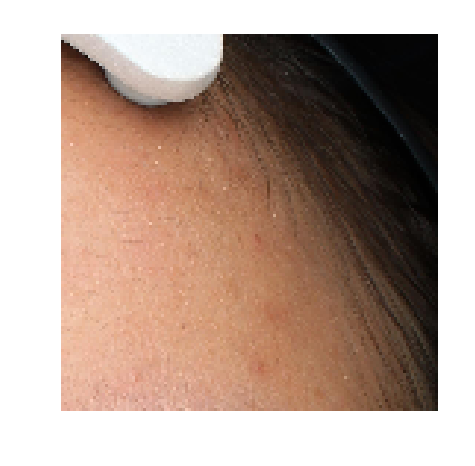

In [14]:

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4080, 4)          min:   -0.17817  max:    0.99077  float32
mAP:  nan


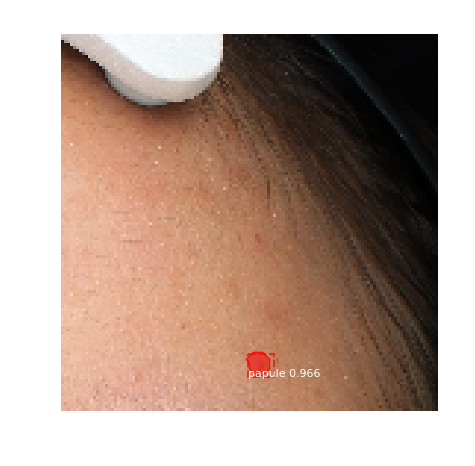

In [15]:

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

In [23]:

# image_ids = np.random.choice(dataset_val.image_ids, 10)
dataset_list = [dataset_train, dataset_val] # dataset_train, dataset_val
for dataset in dataset_list:
    gt_list = []
    r_list = []
    #image_ids = np.random.choice(dataset.image_ids, 200)
    image_ids = dataset.image_ids
    for image_id in image_ids:
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, inference_config,
                                   image_id, use_mini_mask=False)
        gt_list.append({'gt_bbox': gt_bbox, 'gt_class_id': gt_class_id, 'gt_mask': gt_mask})
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
        r_list.append(r)
    
    # Compute AP
#     AP, precision, recall, overlap = utils.compute_ap_Wei(gt_list, r_list)
    AP, precision, recall, overlap = compute_ap_Wei(gt_list, r_list)

    
    print('mAP = %-8.4f precision = %-8.4f recall = %-8.4f' % (AP, precision[-2], recall[-2]))

ValueError: not enough values to unpack (expected 4, got 3)

In [22]:

def compute_overlaps_masks(masks1, masks2):
    """Computes IoU overlaps between two sets of masks.
    masks1, masks2: [Height, Width, instances]
    """
    
    # If either set of masks is empty return empty result
    if masks1.shape[-1] == 0 or masks2.shape[-1] == 0:
        return np.zeros((masks1.shape[-1], masks2.shape[-1]))
    # flatten masks and compute their areas
    masks1 = np.reshape(masks1 > .5, (-1, masks1.shape[-1])).astype(np.float32)
    masks2 = np.reshape(masks2 > .5, (-1, masks2.shape[-1])).astype(np.float32)
    area1 = np.sum(masks1, axis=0)
    area2 = np.sum(masks2, axis=0)

    # intersections and union
    intersections = np.dot(masks1.T, masks2)
    union = area1[:, None] + area2[None, :] - intersections
    overlaps = intersections / union

    return overlaps

def trim_zeros(x):
    """It's common to have tensors larger than the available data and
    pad with zeros. This function removes rows that are all zeros.

    x: [rows, columns].
    """
    assert len(x.shape) == 2
    return x[~np.all(x == 0, axis=1)]

def compute_matches(gt_boxes, gt_class_ids, gt_masks,
                    pred_boxes, pred_class_ids, pred_scores, pred_masks,
                    iou_threshold=0.5, score_threshold=0.0):
    """Finds matches between prediction and ground truth instances.

    Returns:
        gt_match: 1-D array. For each GT box it has the index of the matched
                  predicted box.
        pred_match: 1-D array. For each predicted box, it has the index of
                    the matched ground truth box.
        overlaps: [pred_boxes, gt_boxes] IoU overlaps.
    """
    # Trim zero padding
    # TODO: cleaner to do zero unpadding upstream
    gt_boxes = trim_zeros(gt_boxes)
    gt_masks = gt_masks[..., :gt_boxes.shape[0]]
    pred_boxes = trim_zeros(pred_boxes)
    pred_scores = pred_scores[:pred_boxes.shape[0]]
    # Sort predictions by score from high to low
    indices = np.argsort(pred_scores)[::-1]
    pred_boxes = pred_boxes[indices]
    pred_class_ids = pred_class_ids[indices]
    pred_scores = pred_scores[indices]
    pred_masks = pred_masks[..., indices]

    # Compute IoU overlaps [pred_masks, gt_masks]
    overlaps = compute_overlaps_masks(pred_masks, gt_masks)

    # Loop through predictions and find matching ground truth boxes
    match_count = 0
    pred_match = -1 * np.ones([pred_boxes.shape[0]])
    gt_match = -1 * np.ones([gt_boxes.shape[0]])
    for i in range(len(pred_boxes)):
        # Find best matching ground truth box
        # 1. Sort matches by score
        sorted_ixs = np.argsort(overlaps[i])[::-1]
        # 2. Remove low scores
        low_score_idx = np.where(overlaps[i, sorted_ixs] < score_threshold)[0]
        if low_score_idx.size > 0:
            sorted_ixs = sorted_ixs[:low_score_idx[0]]
        # 3. Find the match
        for j in sorted_ixs:
            # If ground truth box is already matched, go to next one
            if gt_match[j] > -1:
                continue
            # If we reach IoU smaller than the threshold, end the loop
            iou = overlaps[i, j]
            if iou < iou_threshold:
                break
            # Do we have a match?
            if pred_class_ids[i] == gt_class_ids[j]:
                match_count += 1
                gt_match[j] = i
                pred_match[i] = j
                break

    return gt_match, pred_match, overlaps


def compute_ap(gt_boxes, gt_class_ids, gt_masks,
               pred_boxes, pred_class_ids, pred_scores, pred_masks,
               iou_threshold=0.5):
    """Compute Average Precision at a set IoU threshold (default 0.5).

    Returns:
    mAP: Mean Average Precision
    precisions: List of precisions at different class score thresholds.
    recalls: List of recall values at different class score thresholds.
    overlaps: [pred_boxes, gt_boxes] IoU overlaps.
    """
    # Get matches and overlaps
    gt_match, pred_match, overlaps = compute_matches(
        gt_boxes, gt_class_ids, gt_masks,
        pred_boxes, pred_class_ids, pred_scores, pred_masks,
        iou_threshold)

    # Compute precision and recall at each prediction box step
    precisions = np.cumsum(pred_match > -1) / (np.arange(len(pred_match)) + 1)
    recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)

    # Pad with start and end values to simplify the math
    precisions = np.concatenate([[0], precisions, [0]])
    recalls = np.concatenate([[0], recalls, [1]])

    # Ensure precision values decrease but don't increase. This way, the
    # precision value at each recall threshold is the maximum it can be
    # for all following recall thresholds, as specified by the VOC paper.
    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = np.maximum(precisions[i], precisions[i + 1])

    # Compute mean AP over recall range
    indices = np.where(recalls[:-1] != recalls[1:])[0] + 1
    mAP = np.sum((recalls[indices] - recalls[indices - 1]) *
                 precisions[indices])

    return mAP, precisions, recalls, overlaps


def compute_ap_Wei(gt_list, r_list, iou_threshold=0.5):
    gt_match = []
    pred_match = []
    pred_scores_arr = []
    for i in range(len(gt_list)):
        gt_boxes = gt_list[i]['gt_bbox']
        gt_class_ids = gt_list[i]['gt_class_id']
        gt_masks = gt_list[i]['gt_mask']
        pred_boxes = r_list[i]['rois']
        pred_class_ids = r_list[i]['class_ids']
        pred_scores = r_list[i]['scores']
        pred_masks = r_list[i]['masks']

        # Get matches and overlaps
        _gt_match, _pred_match, overlaps, _pred_scores_arr = compute_matches(
            gt_boxes, gt_class_ids, gt_masks,
            pred_boxes, pred_class_ids, pred_scores, pred_masks,
            iou_threshold)

        gt_match = np.concatenate((gt_match, _gt_match))
        pred_match = np.concatenate((pred_match, _pred_match))
        pred_scores_arr = np.concatenate((pred_scores_arr, _pred_scores_arr))

    indices = np.argsort(pred_scores_arr)[::-1]
    pred_match = pred_match[indices]
    
    # Compute precision and recall at each prediction box step
    precisions = np.cumsum(pred_match > -1) / (np.arange(len(pred_match)) + 1)
    recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)

    # Pad with start and end values to simplify the math
    precisions = np.concatenate([[0], precisions, [0]])
    recalls = np.concatenate([[0], recalls, [1]])

    # Ensure precision values decrease but don't increase. This way, the
    # precision value at each recall threshold is the maximum it can be
    # for all following recall thresholds, as specified by the VOC paper.
    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = np.maximum(precisions[i], precisions[i + 1])

    # Compute mean AP over recall range
    indices = np.where(recalls[:-1] != recalls[1:])[0] + 1
    mAP = np.sum((recalls[indices] - recalls[indices - 1]) *
                 precisions[indices])

    return mAP, precisions, recalls, overlaps